# PD Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [2]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')
import matplotlib_venn
from scipy import stats
import scipy.stats as stats
from sklearn import cross_validation
from collections import Counter

## Preprocessing

In [3]:
# file directories
workingDirectory = '/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis/'
genomes = ['hg38','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath= workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
# if not os.path.isfile("nameMapping.tsv"):
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(logFilePath):
    rootName = f
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[2].strip()
    owner = metaDataTokens[3].strip()
    date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = '-'.join([x for x in t.split('-')][:-1])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
    rootName = logFile
    for gen in genomes:
        rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
    totalReads = int(data[5].split()[5])
    uniquelyMappedReads = int(data[8].split()[5])
    multiMappedReads = int(data[23].split()[8])
    unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
#     pbc = float(data[-1].split()[-1])

    _originalNames.append(rootName)
    _totalReads.append(totalReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:151: FutureWarning: sort(....) is deprecated, use sort_index(.....)


## Mapping Quality Control

### Plot Distributions of Mapping Statistics

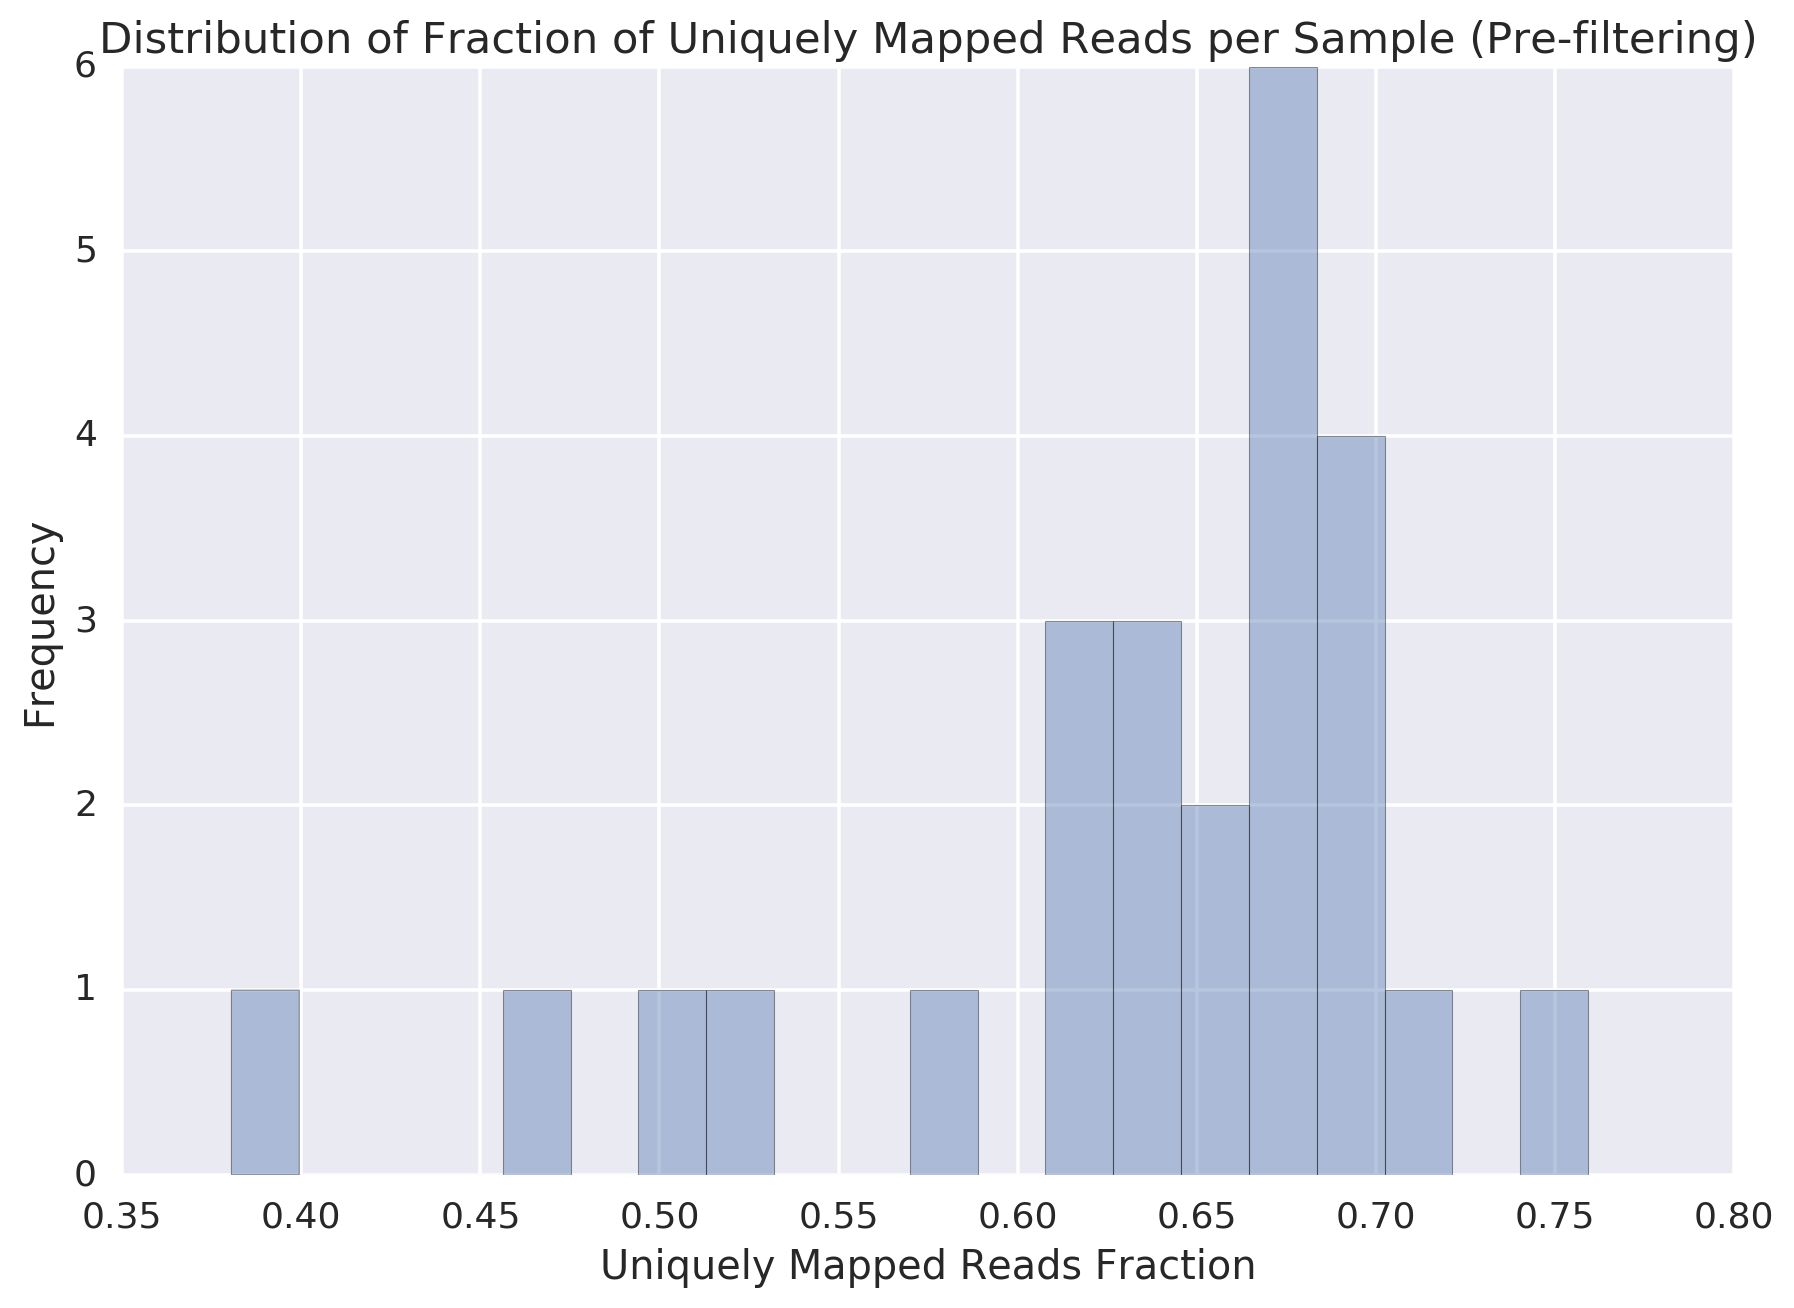

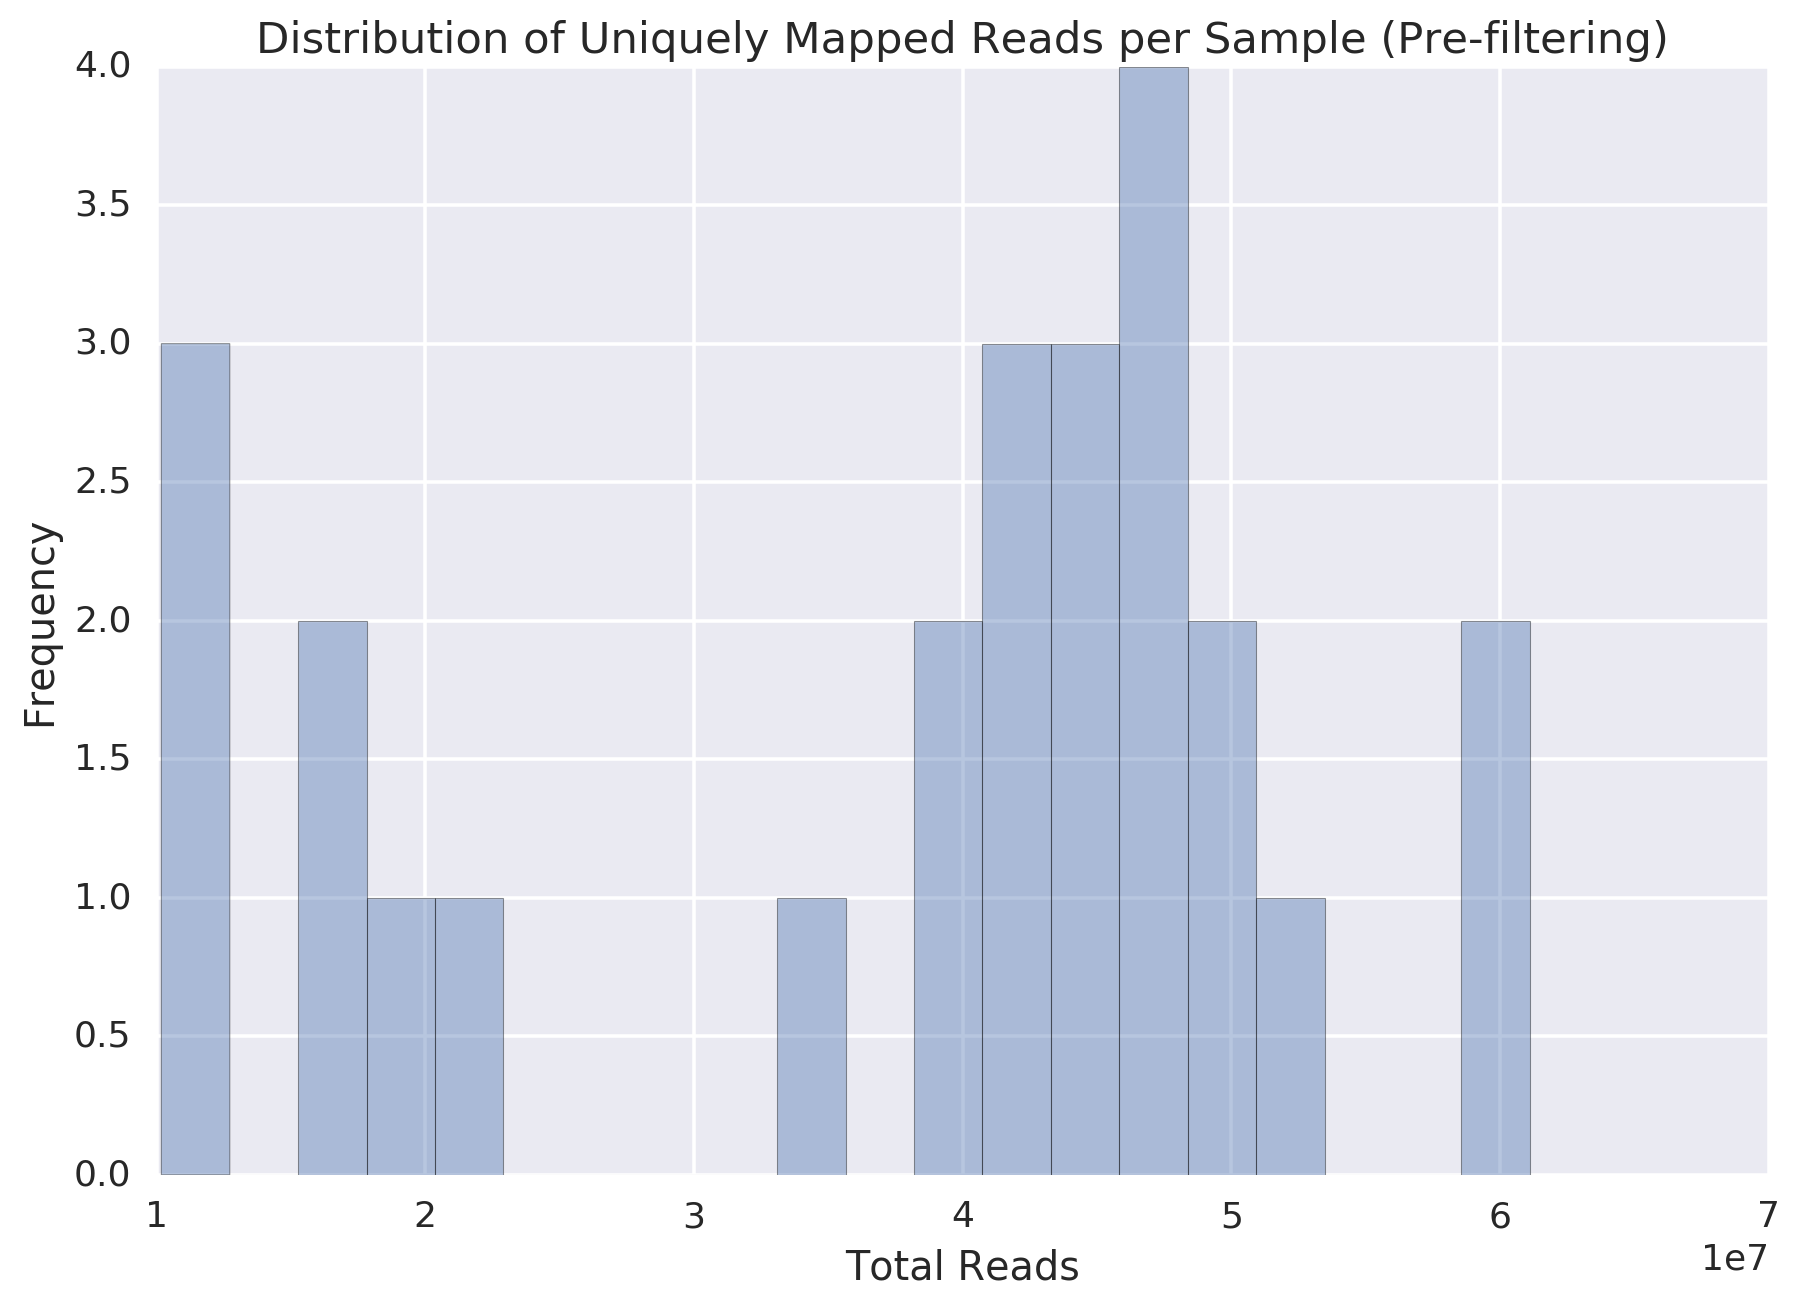

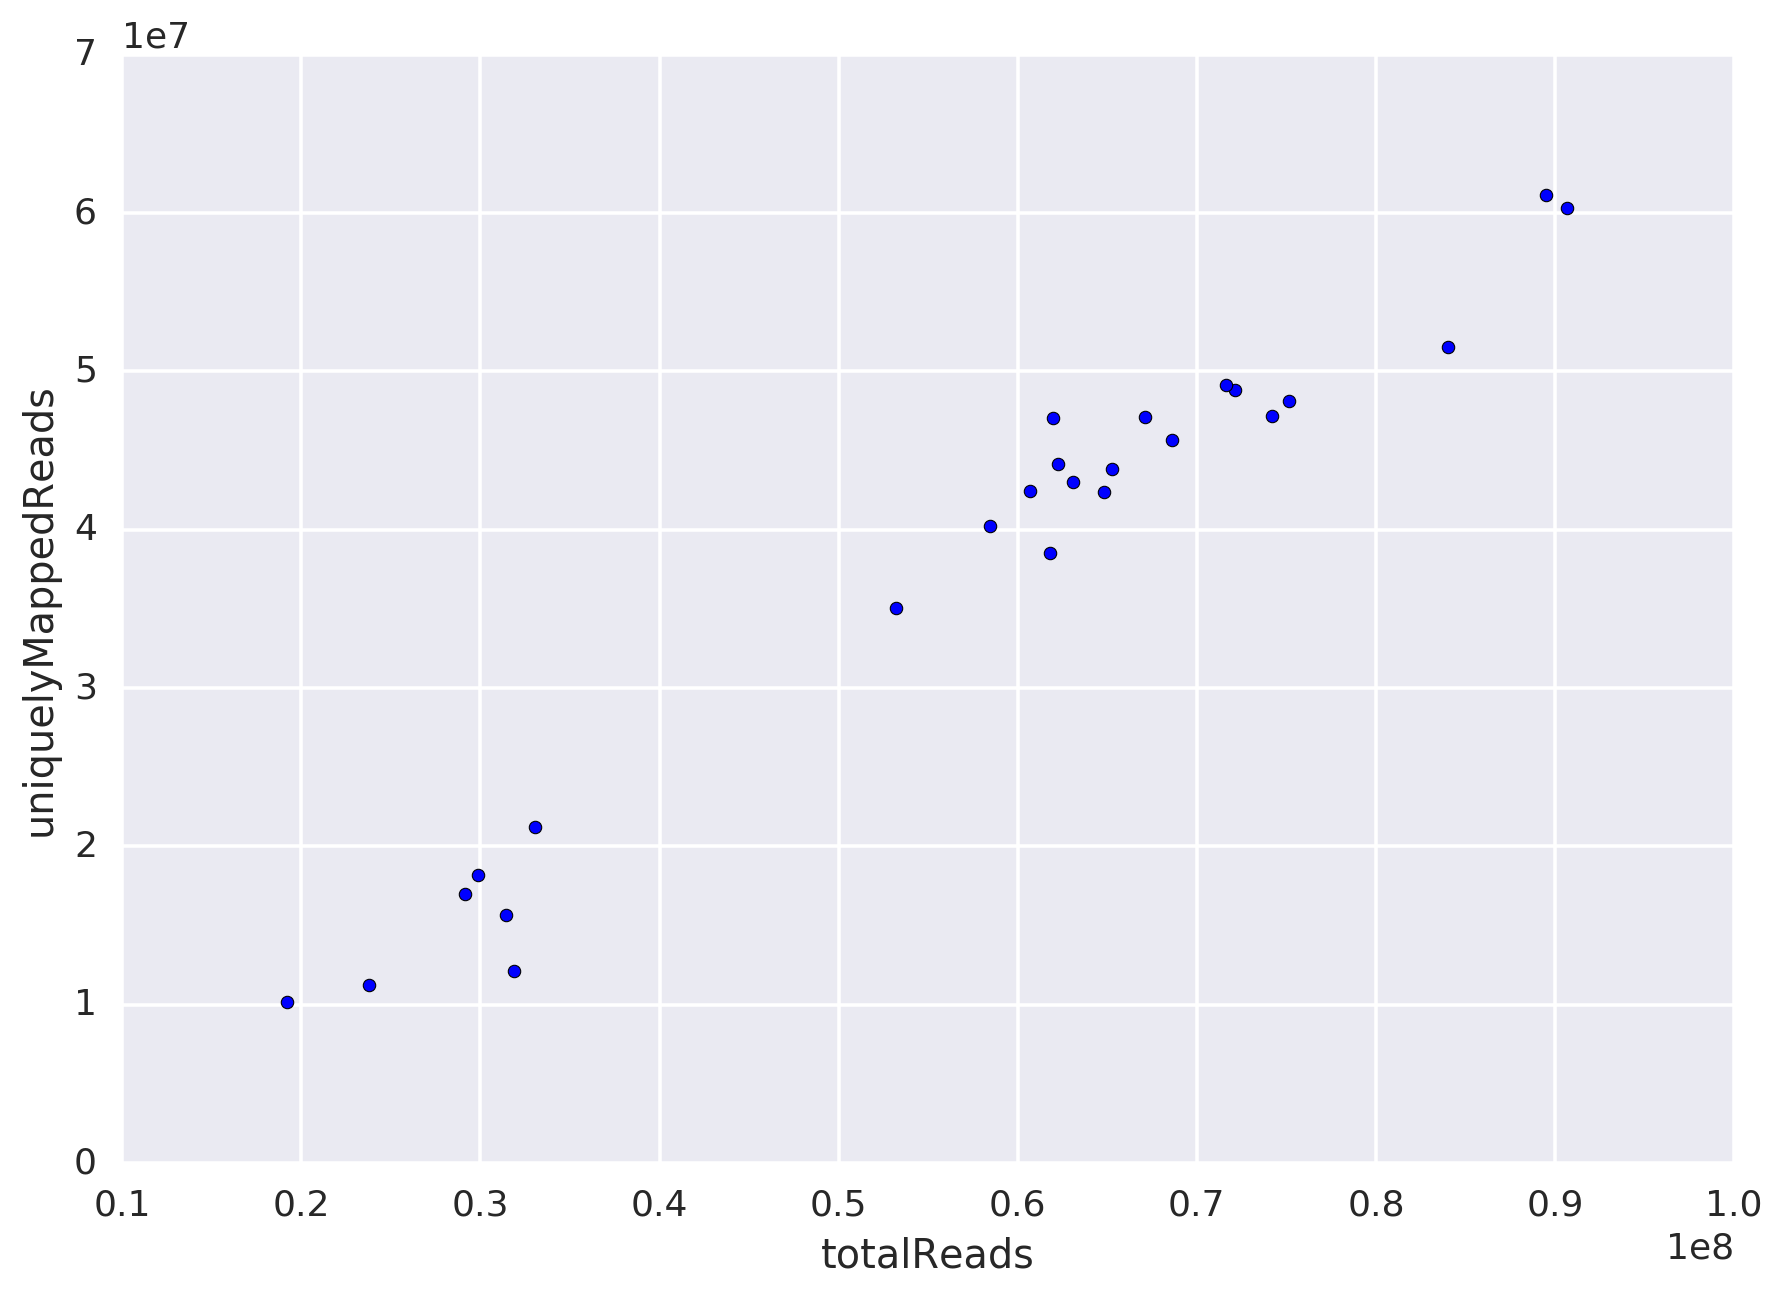

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


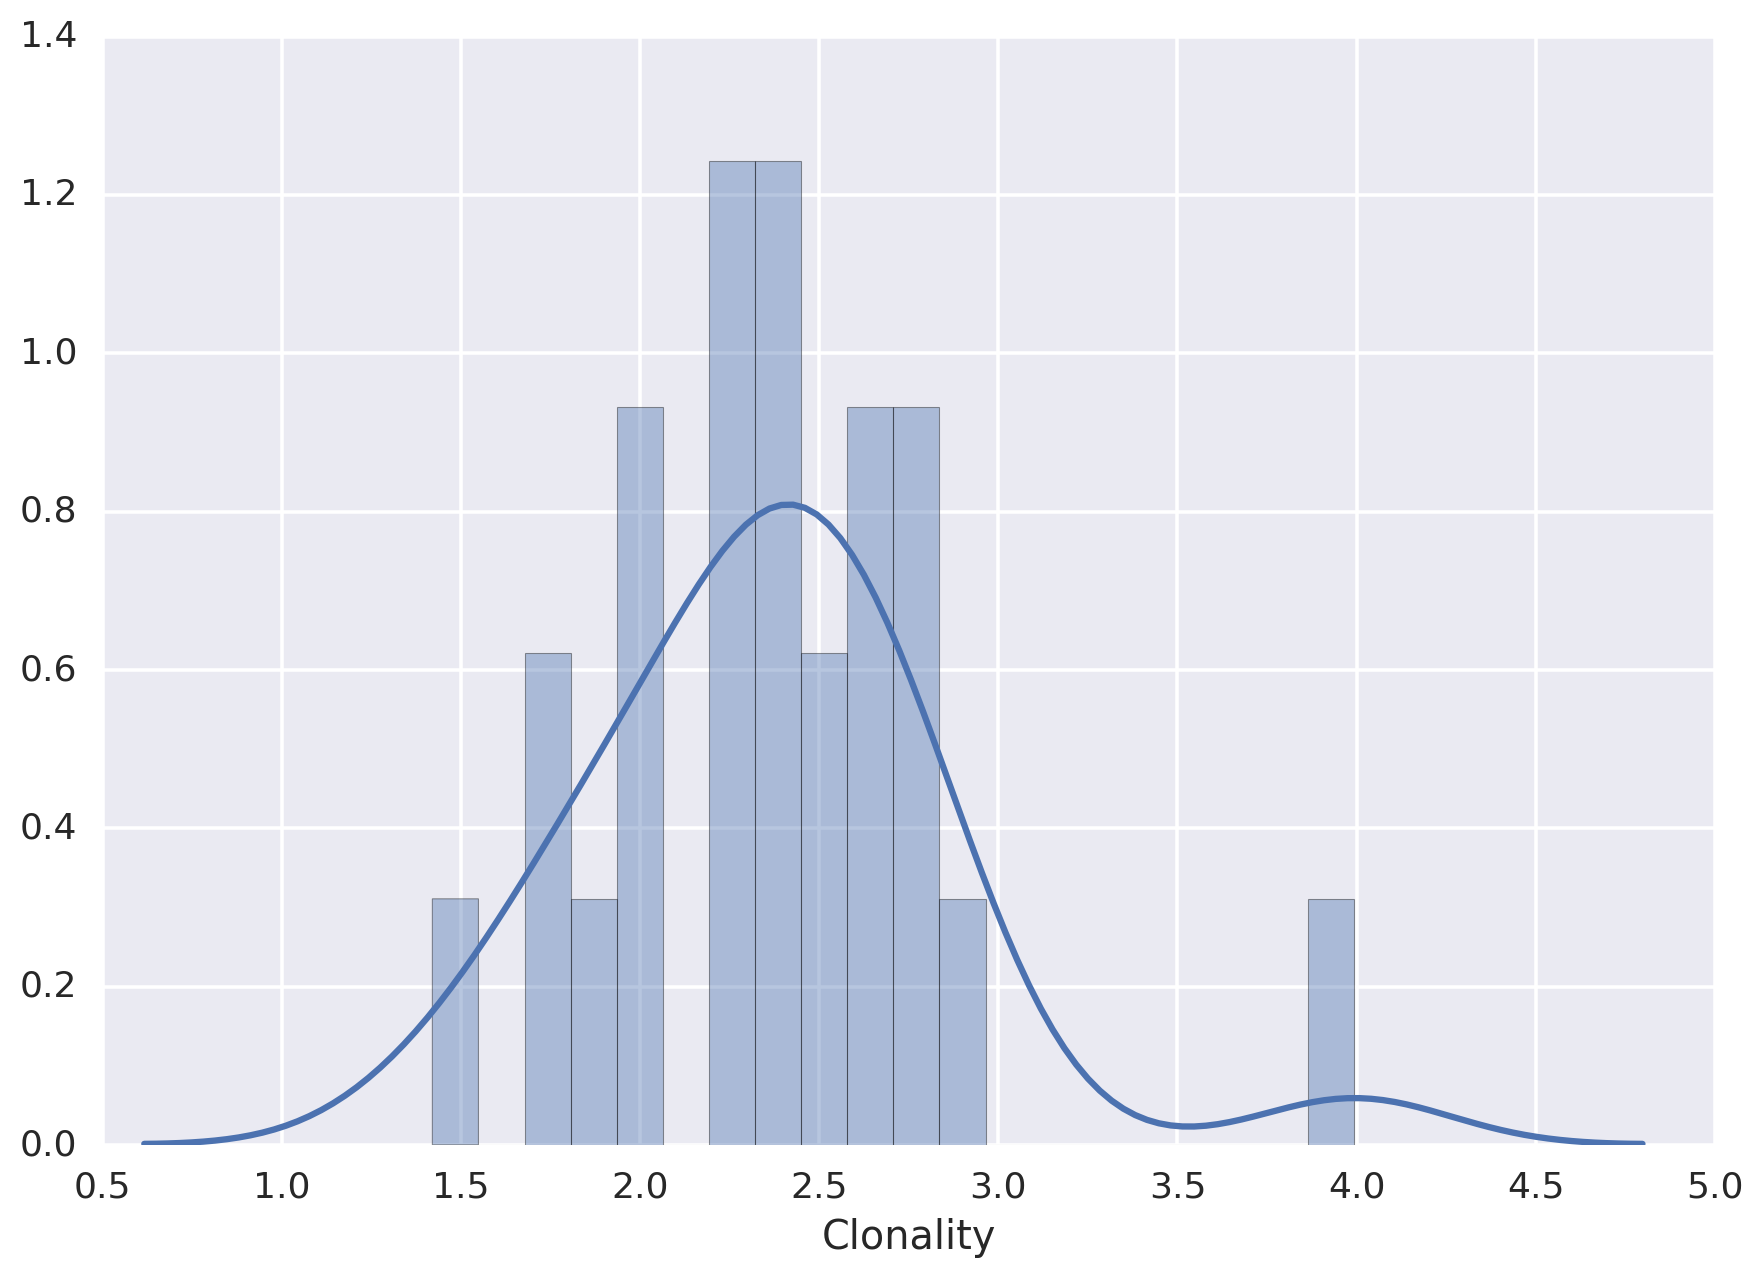

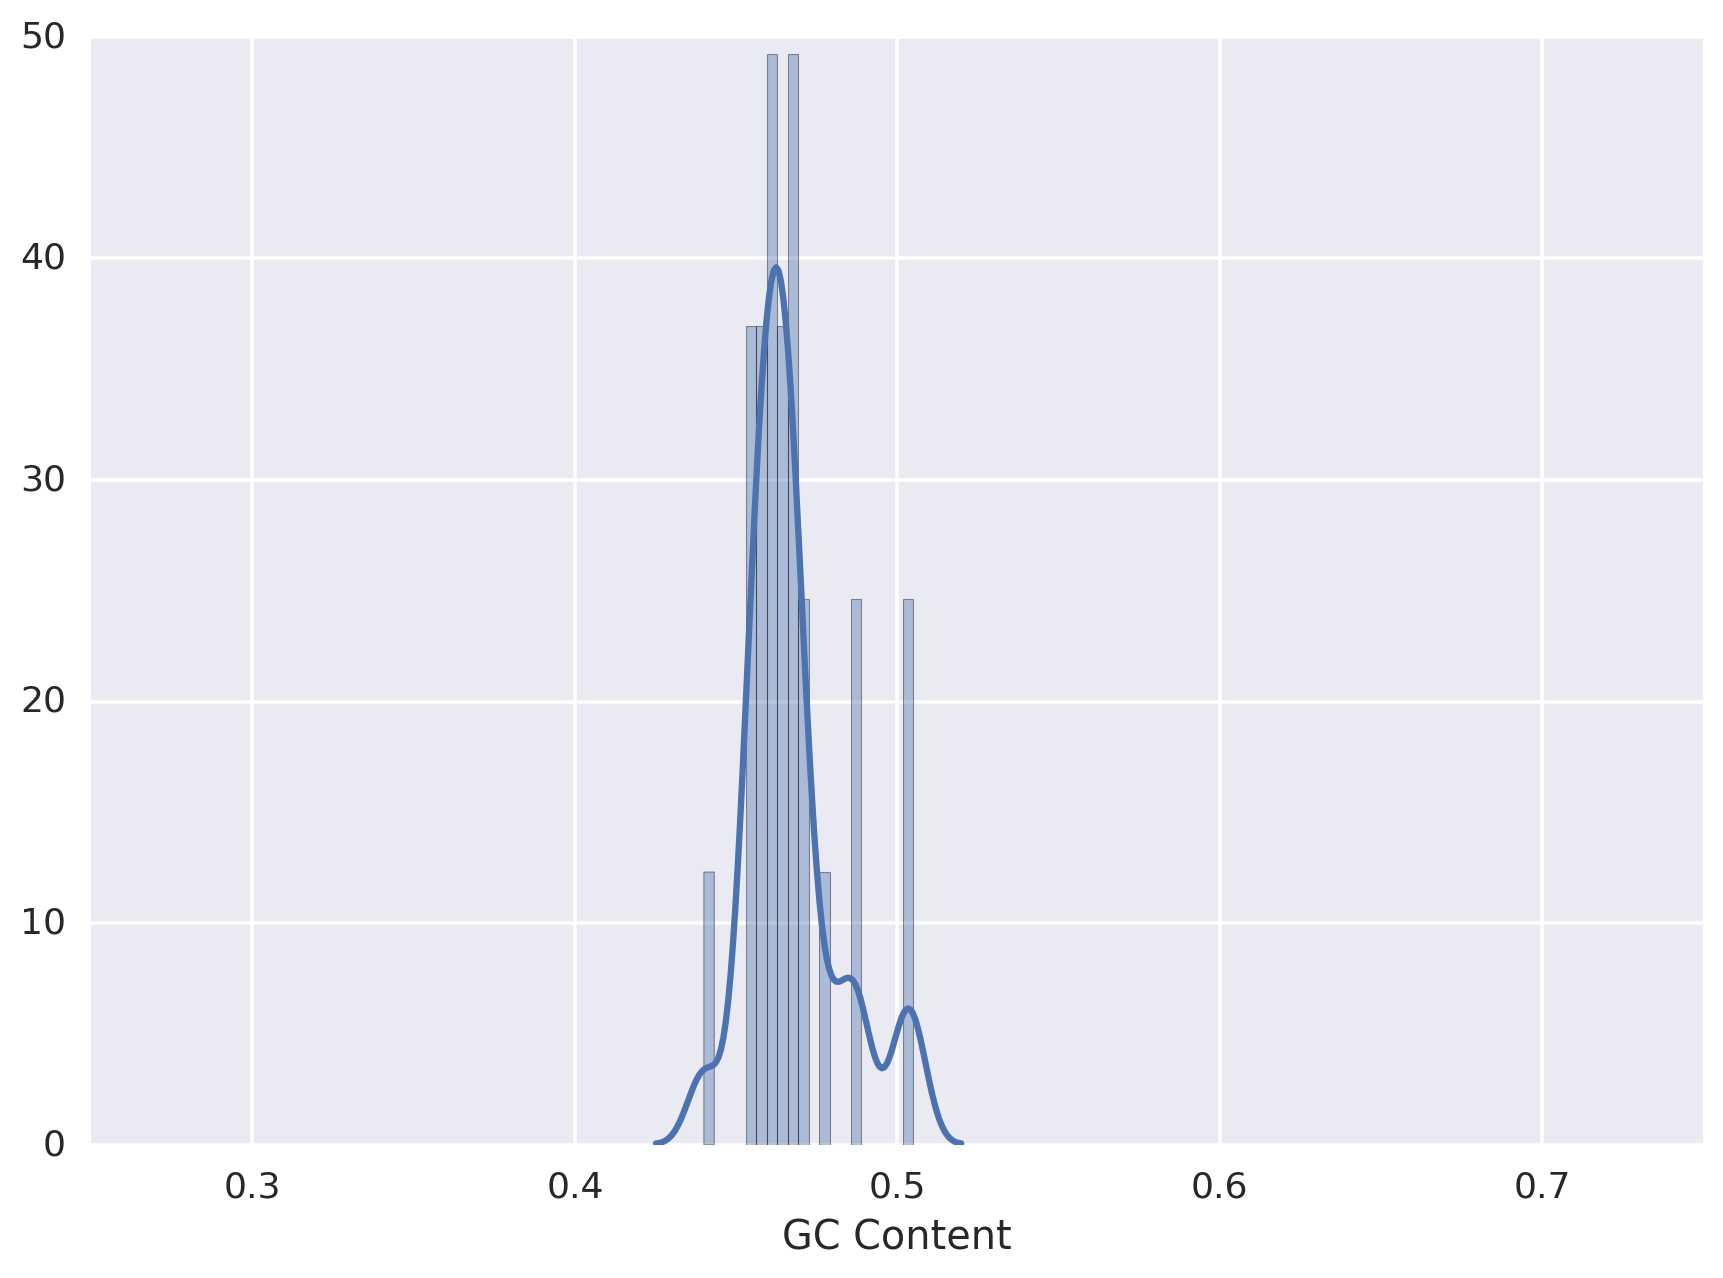

In [4]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.xlabel('totalReads')
plt.ylabel('uniquelyMappedReads')
plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
plt.xlim([0.25,0.75])
plt.show()



### Filter Samples According to Mapping Quality

In [7]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 5000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 3.5
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []

simplifiedNames = [x.split('_')[2] for x in filtered_summary_frame['originalName'].values]

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

Number of Samples: 25
Number of discarded samples: 1
Number of Samples remaining after filtering: 24


In [8]:
advanced_patients = ['PD-13', 'PD-07', 'PD-16', 'Control-32', 'Control-34']
filtered_summary_frame = filtered_summary_frame[~filtered_summary_frame['treatment'].isin(advanced_patients)]
print(filtered_summary_frame.shape)

(19, 20)


## Calculate Tag Counts and RPKM

In [10]:
# %%capture
filteredTagDirectories = ' '.join([tagDirPath +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >./rpkm.tsv
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >./raw.tsv
# !analyzeRepeats.pl rna hg38 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/normed.tsv

# !analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories/* > rpkm_all.tsv



	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-48_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-37_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-26_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-44_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-49_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-17_JS_13-05-15
		/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-30_JS_14-02-26
		/gpfs/data01/glasslab/home/jtao/ana

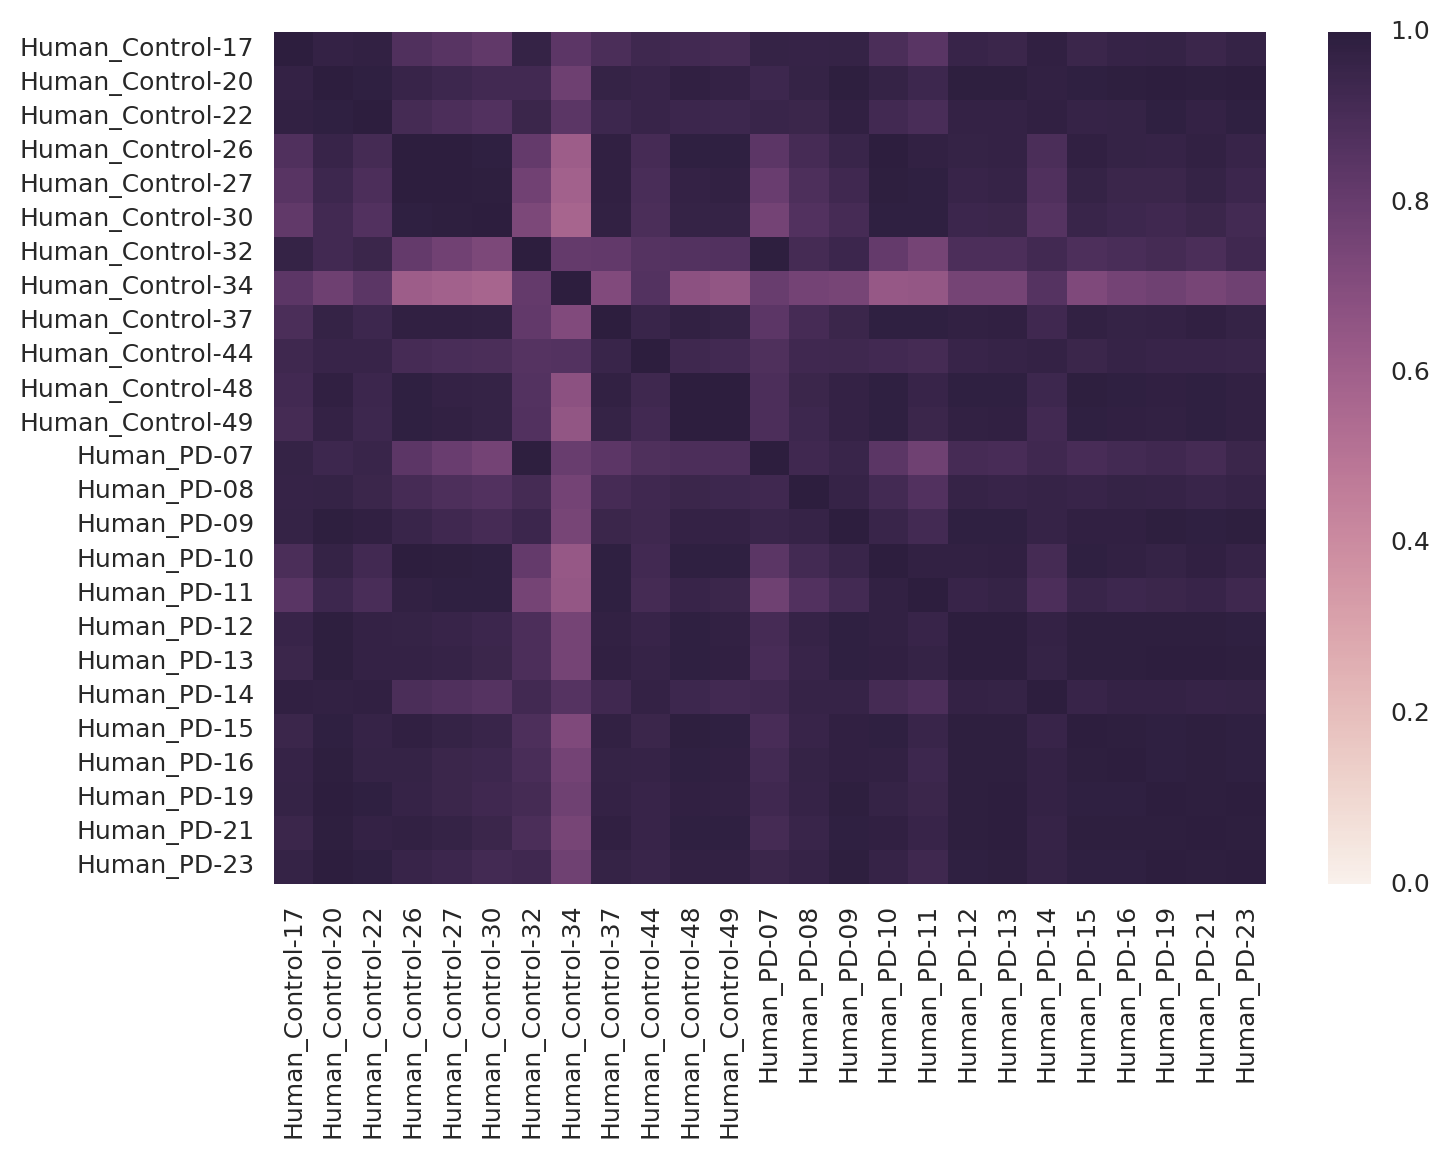

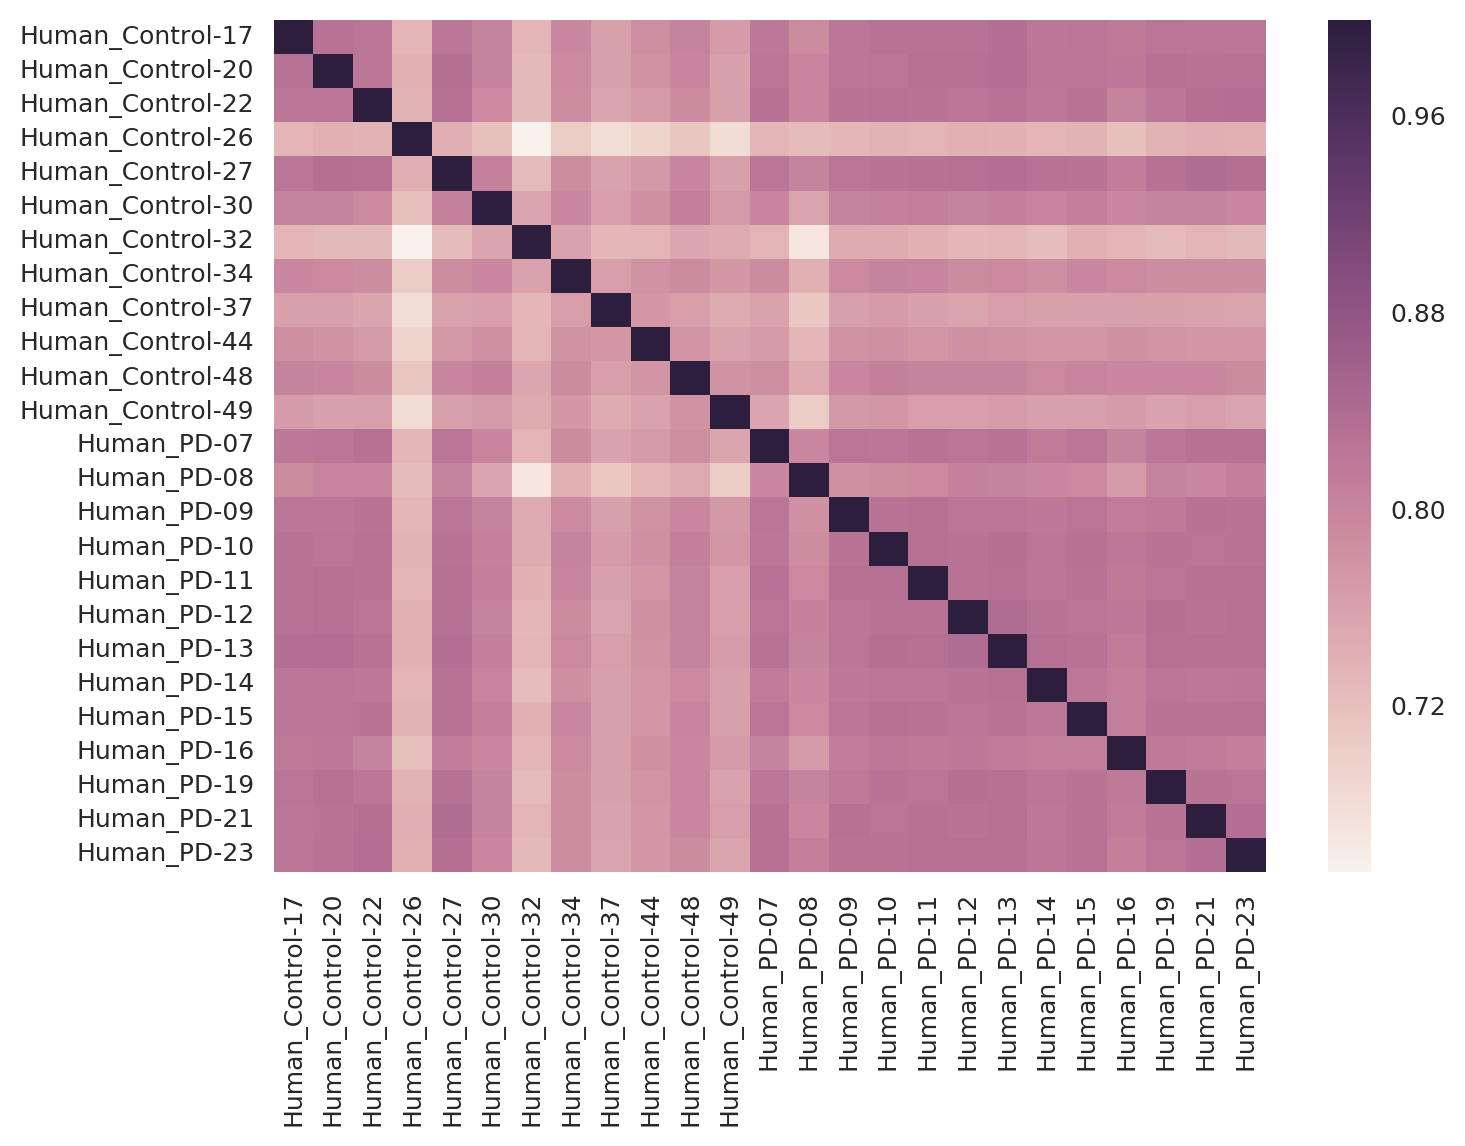

In [9]:
all_rpkm_frame = pd.read_csv("rpkm_all.tsv",sep="\t")
columns = all_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
all_rpkm_frame.columns = columns    
all_rpkm_frame['gene'] = [x.split("|")[0] for x in all_rpkm_frame['Annotation/Divergence']]
columns = list(all_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
all_rpkm_frame = all_rpkm_frame[columns]


### cluster samples according to correlation
samples = all_rpkm_frame.columns.values[9:]

labels = ['_'.join(x.split('_')[0:3]).replace('RNA_','') for x in columns[9:]]

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
for i in range(len(samples)):
    spearman_matrix[i][i]=1.0
    pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = all_rpkm_frame[samples[i]].values
        values_2 = all_rpkm_frame[samples[j]].values
        pearson, pearson_pval = stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
        

sns.set_context('notebook', font_scale=0.9)
cg = sns.heatmap(pearson_matrix, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

cg = sns.heatmap(spearman_matrix, xticklabels=labels, yticklabels=labels)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

sns.set_context('notebook', font_scale=1.0)

In [ ]:
if not os.path.isdir('scatter_plots'):
    os.mkdir('scatter_plots')
treatments = sorted(list(set(summary_frame.index)))
for i in range(len(treatments)):
    for j in range(i, len(treatments)):
        print(treatments[i], treatments[j])
        columns = sorted(list(set(list(summary_frame.loc[treatments[i],'originalName']) + 
                              list(summary_frame.loc[treatments[j],'originalName']))))
        data = np.log2(all_rpkm_frame.loc[:,columns] + 1)
        data = data[data.sum(axis=1) > 0.0]
        data.columns = ['_'.join(x.split('_')[0:3]).replace('Human-HMDM-','').replace('RNA_','') for x in columns]
        print(data.columns)
        cg = sns.pairplot(data, 
                          x_vars=[x for x in data.columns.values if treatments[i][1] in x],
                          y_vars=[x for x in data.columns.values if treatments[j][1] in x]
                         )
        
        plt.savefig('./scatter_plots/' + '_'.join(treatments[i] + treatments[j]) + '_logRpkm.png')
        plt.close()

In [10]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# # read in tag counts
# reads_frame = pd.read_csv("normed.tsv",sep="\t")
# columns = reads_frame.columns.values
# columns[0] = "refseq"
# for i in range(len(columns)):
#     if "reads" in columns[i]:
#         columns[i] = columns[i].split("/")[-1].split()[0]
# reads_frame.columns = columns  
# reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
# columns = list(reads_frame.columns.values)
# columns = columns[:-1]
# columns.insert(1,'gene')
# reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values

columns = [columns[0]] + [x.strip().split('/')[-1].split()[0] if 'tag_directories' in x else x for x in columns[1:]]
raw_frame.columns = columns

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0].upper() for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
columns = [x.split('_')[2] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
# filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 10.0]
to_write_frame = filtered_rpkm_frame.copy()
to_write_frame = to_write_frame[to_write_frame.max(axis=1) > 1.0]
to_write_frame.index = [refseq_gene_mapping[x] for x in to_write_frame.index.values]
to_write_frame.to_csv('filtered_rpkm.tsv', sep='\t')
# create frame that's easier to use with factor plots

pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq].upper()
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)



ERROR! Session/line number was not unique in database. History logging moved to new session 577


## Run IDR

In [23]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!python /gpfs/data01/glasslab/home/jtao/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

Output files will be written to: /gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//idr/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-48_JS_14-02-26 FPKM 	 Control
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-37_JS_14-02-26 FPKM 	 Control
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-26_JS_13-05-15 FPKM 	 Control
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-44_JS_14-02-26 FPKM 	 Control
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-49_JS_14-02-26 FPKM 	 Control
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15 FPKM 	 Control
/gpfs/data01/glasslab/home/jtao/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_J

In [11]:
idr_rpkm_frame = pd.read_csv('idr/idr_union.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
#         columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
        columns[i] =columns[i].split("/")[-1].split()[0].split('_')[2]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = [x.upper() for x in idr_rpkm_frame['gene'].values]
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = col.split('-')[0]
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame.index = idr_rpkm_frame.index.values

idr_rpkm_median_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    treatment = col.split('-')[0]
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_median_frame[treatment] = np.median(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)

idr_rpkm_median_frame.index = idr_rpkm_frame.index.values

## Calcuate Differential Expression with EdgeR

In [12]:
run_genes_dict = {} # {excludedSamples:{significantGenes}}

In [202]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
samples = [x.split('/')[-1].split()[0] for x in raw_frame.columns[8:].values]

conditions = " ".join([sample_condition_dict[x] for x in samples])
!getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 4 (0.015%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 63 (0.237%) [log2fold<-1, FDR<0.05]



In [14]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [93]:
run_genes_dict['All Patients'] = set(diffExpression_frame[diffExpression_frame['Control vs. PD adj. p-value'] <0.05]['gene'].values)



In [127]:
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))

samples = sorted(set(filtered_summary_frame['originalName'].values))
treatments = [sample_condition_dict[x] for x in samples]
labels = treatments
run_excluded_dict = {} #{run:[excludedSamples]}

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
numExcluded = 4
for test_indices, exclude_indices in skf:
    runNumber += 1

    # get samples to use
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    print('***', runNumber, len(exclude_indices))
    print(excluded_samples)
    run_excluded_dict[runNumber] = excluded_samples
    # create raw.tsv for current cross-validation set
    current_raw_frame = raw_frame[list(raw_frame.columns.values[:8]) + test_samples]
    columns = current_raw_frame.columns.values
#     columns[0] = 'Transcript/RepeatID (cmd=' + ' '.join(test_samples) + ')'
    current_raw_frame.columns = columns
    current_raw_path = 'raw_' + str(runNumber) + '.tsv'
    current_raw_frame.to_csv(current_raw_path, index=False, sep='\t')
    conditions = " ".join([sample_condition_dict[x] for x in test_samples])
    
    # call EdgeR
    current_diffExpression_path = 'homer_diffExpression_' + str(runNumber) + '.tsv'
    ! getDiffExpression.pl $current_raw_path $conditions > $current_diffExpression_path
    

*** 1 4
['Human_RNA_Control-20_JS_13-05-15', 'Human_RNA_Control-27_JS_13-05-15', 'Human_RNA_PD-08_JS_13-05-15', 'Human_RNA_PD-11_JS_13-05-15']

	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 1 (0.004%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. Control: 56 (0.211%) [log2fold<-1, FDR<0.05]

*** 2 4
['Human_RNA_Control-37_JS_14-02-26', 'Human_RNA_Control-49_JS_14-02-26', 'Human_RNA_PD-12_JS_13-05-15', 'Human_RNA_PD-21_JS_13-05-15']

	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Control vs. PD:
		Total Genes: 26549
		Total Up-regulated in PD vs. Control: 2 (0.008%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PD vs. 

In [128]:
significant_genes_intersection = None
significant_genes_union = set()

for i in range(1,6):
    # read current differentially expressed gene output
    current_path = 'homer_diffExpression_' + str(i) + '.tsv'
    current_diffExpression_frame = pd.read_csv(current_path, sep='\t')
    columns = current_diffExpression_frame.columns.values
    columns[0]='refseq'
    columns = [x.split('/')[-1] if '/' in x else x for x in columns]
    current_diffExpression_frame.columns=columns
    current_diffExpression_frame.index = current_diffExpression_frame.refseq.values
    current_diffExpression_frame['gene'] = [x.split('|')[0].upper() for x in current_diffExpression_frame['Divergence']]
    columns = ['refseq', 'gene'] + [x for x in current_diffExpression_frame.columns if 'vs.' in x]
    current_diffExpression_frame = current_diffExpression_frame[columns]
    
    significant_genes = set(current_diffExpression_frame[current_diffExpression_frame['Control vs. PD adj. p-value'] <0.05]['gene'].values)

    print(len(significant_genes))    
    run_genes_dict[str(i)]  = significant_genes
    if significant_genes_intersection == None:

        significant_genes_intersection  = significant_genes
    else:
        significant_genes_intersection = significant_genes_intersection.intersection(significant_genes)
    significant_genes_union = significant_genes_union.union(significant_genes)

57
2
2
91
34


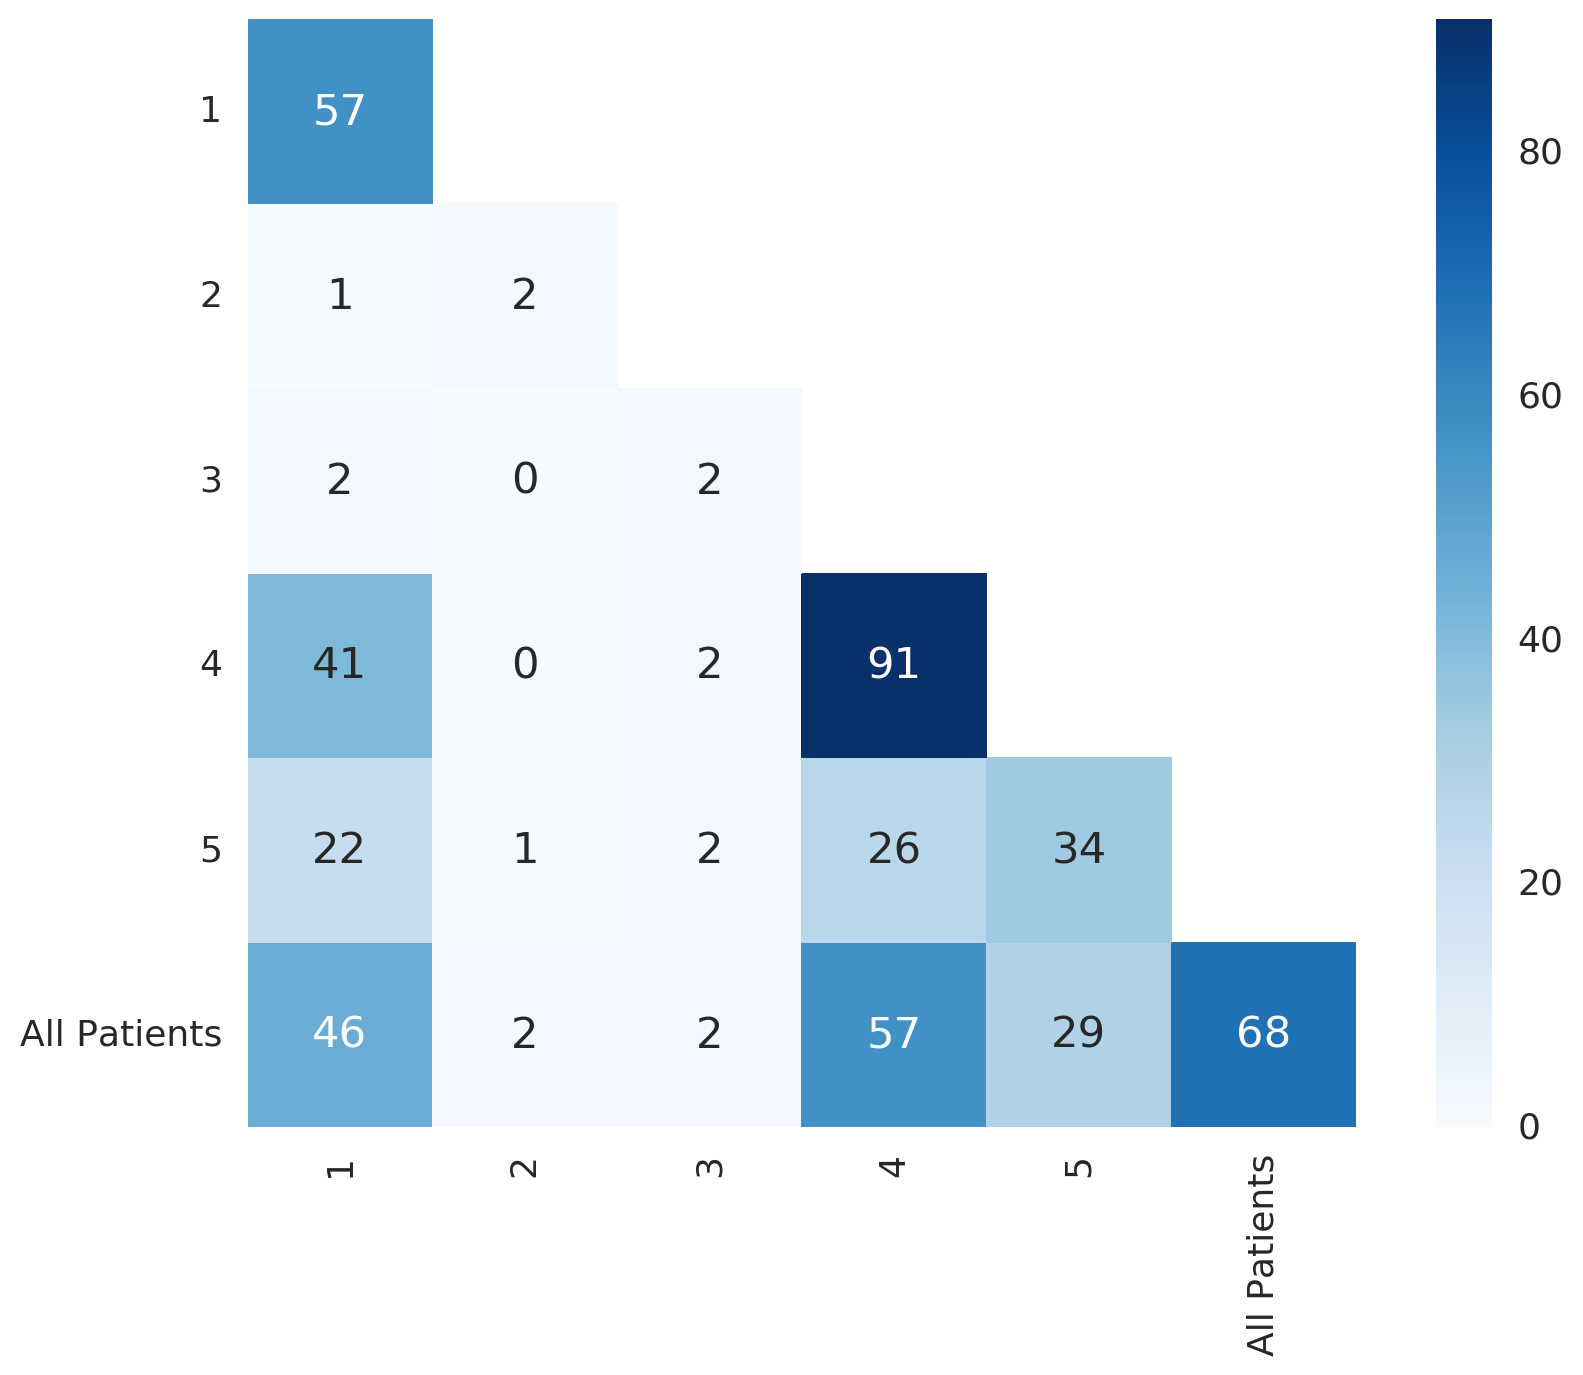

In [129]:
sorted_keys = sorted(run_genes_dict.keys())
matrix = np.zeros((6,6))
for i in range(matrix.shape[0] - 1):
    key_1 = sorted_keys[i]
    genes_1 = run_genes_dict[key_1]
    matrix[i][i] = len(genes_1)
    for j in range(i + 1, matrix.shape[0]):
        key_2 = sorted_keys[j]
        genes_2 = run_genes_dict[key_2]
        intersection = genes_1.intersection(genes_2)
        matrix[j][i] = len(intersection)
matrix[5][5] = len(run_genes_dict['All Patients'])
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
for i in range(6):
    mask[i][i]=False
with sns.axes_style("white"):
    sns.heatmap(matrix, 
                mask=mask,
                xticklabels= sorted_keys,
                yticklabels = sorted_keys,
                cmap='Blues',
                fmt='g',
                annot=True,
                square=True)
    plt.yticks(rotation=0)  
    plt.xticks(rotation=90)  
    plt.savefig('./figures/cross_validation_overlap.pdf',bbox_inches='tight')

In [95]:

# # ### generate R code for chow-ruskey diagram ###
# venn_script = open('chowRuskey_script.R','w')
# venn_script.write('library(Vennerable);\n')
# sorted_keys = sorted(run_genes_dict.keys())
# for run in sorted_keys :
#     indices = run_genes_dict[run]
#     venn_script.write(run + '_ids <- list(' + ','.join(["'"+x+"'" for x in indices]) + ');\n')
#     venn_script.write(run+'_ids.name <-"'+run+'";\n')
# venn_script.write('venn_ids <- list(' + ','.join([x+'_ids' for x in sorted_keys]) + ');\n')
# venn_script.write('venn_object <- Venn(venn_ids);\n')
# venn_script.write('pdf("venn_chowRuskey.pdf")\n')
# venn_script.write('plot(venn_object,type="ChowRuskey")\n')
# venn_script.write('dev.off()')
# venn_script.close()


## Statistical Testing

In [124]:
refseqs = []
kw_pvals = []
kw_stats = []
ks_pvals = []
ks_stats = []
genes = []
up_down = []
fold= []
idr_genes = set(idr_rpkm_frame.index.values)
for refseq in set(filtered_rpkm_plottingFrame['refseq'].values):

    gene = refseq_gene_mapping[refseq]
    if gene in idr_genes:
        currentVals = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['refseq'] == refseq]
        
        control_vals = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
        pd_vals = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values
#         ks_stat, p_ks = stats.ks_2samp(control_vals, pd_vals)
        kw_stat, p_kw = stats.kruskal(control_vals, pd_vals)
        
        kw_pvals.append(p_kw)
#         ks_pvals.append(p_ks)
        
        kw_stats.append(kw_stat)
#         ks_stats.append(ks_stat)
        
        genes.append(gene)
        refseqs.append(refseq)
        
        mean_control = np.mean(control_vals)
        mean_pd = np.mean(pd_vals)
        if mean_control < mean_pd:
            up_down.append('up')
        else:
            up_down.append('down')
        fold.append(mean_pd/mean_control)
        
passed_idr = [True if x in idr_genes else False for x in genes]
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD p-value'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]
stat_frame = pd.DataFrame({'gene':genes,
                            'refseq':refseqs,
#                             'KS pval':ks_pvals,
#                             'KS stat':ks_stats,
                            'KW pval':kw_pvals,
                            'KW stat':kw_stats,
                            'passed IDR': passed_idr,
                            'EdgeR pval':edger_pvals,
                            'Up or Down':up_down,
                           'fold change':fold
                           }) 

## Cross Validation

In [196]:
idr_genes = set(idr_rpkm_frame.index.values)

samples = sorted(set(filtered_rpkm_plottingFrame['simplifiedName'].values))
treatments = [x.split('-')[0] for x in samples]
labels = treatments

refseqs = []
kw_pvals = []
kw_stats = []
genes = []
up_down = []
run = []

skf = cross_validation.StratifiedKFold(labels, 5, shuffle=True)
runNumber = 0
for test_indices, exclude_indices in skf:
    runNumber += 1
    print(runNumber)
    test_samples = [samples[i] for i in test_indices]
    excluded_samples = [samples[i] for i in exclude_indices]
    current_frame = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['simplifiedName'].isin(
        test_samples)]
    print("%s %s" % (test_indices, exclude_indices))
    print("%s %s" % (test_samples, excluded_samples))
    

    for refseq in set(current_frame['refseq'].values):
        gene = refseq_gene_mapping[refseq]
        if gene in idr_genes:
            run.append(runNumber)
            currentVals = current_frame[current_frame['refseq'] == refseq]

            control_vals = currentVals[currentVals['treatment'] == 'Control']['rpkm'].values
            pd_vals = currentVals[currentVals['treatment'] == 'PD']['rpkm'].values
            
            kw_stat, p_kw = stats.kruskal(control_vals, pd_vals)

            kw_pvals.append(p_kw)
            kw_stats.append(kw_stat)

            genes.append(gene)
            refseqs.append(refseq)

            if np.mean(control_vals) < np.mean(pd_vals):
                up_down.append('up')
            else:
                up_down.append('down')
        
gene_edgerp_dict = dict(zip(diffExpression_frame['gene'], diffExpression_frame['Control vs. PD p-value'].values))
edger_pvals = [gene_edgerp_dict[x] if x in gene_edgerp_dict else 1.0 for x in genes]
cv_frame = pd.DataFrame({'gene':genes,
                            'refseq':refseqs,
                            'KW pval':kw_pvals,
                            'KW stat':kw_stats,
                            'EdgeR pval':edger_pvals,
                            'Up or Down':up_down,
                            'Run':run
                           }) 

1
[ 0  1  2  3  4  6  8  9 11 12 13 14 15 17 18] [ 5  7 10 16]
['Control-17', 'Control-20', 'Control-22', 'Control-26', 'Control-27', 'Control-37', 'Control-48', 'Control-49', 'PD-09', 'PD-10', 'PD-11', 'PD-12', 'PD-14', 'PD-21', 'PD-23'] ['Control-30', 'Control-44', 'PD-08', 'PD-15']
2
[ 1  2  3  4  5  7  8  9 10 12 13 14 16 17 18] [ 0  6 11 15]
['Control-20', 'Control-22', 'Control-26', 'Control-27', 'Control-30', 'Control-44', 'Control-48', 'Control-49', 'PD-08', 'PD-10', 'PD-11', 'PD-12', 'PD-15', 'PD-21', 'PD-23'] ['Control-17', 'Control-37', 'PD-09', 'PD-14']
3
[ 0  1  2  5  6  7  8  9 10 11 13 14 15 16 18] [ 3  4 12 17]
['Control-17', 'Control-20', 'Control-22', 'Control-30', 'Control-37', 'Control-44', 'Control-48', 'Control-49', 'PD-08', 'PD-09', 'PD-11', 'PD-12', 'PD-14', 'PD-15', 'PD-23'] ['Control-26', 'Control-27', 'PD-10', 'PD-21']
4
[ 0  1  3  4  5  6  7  8 10 11 12 14 15 16 17] [ 2  9 13 18]
['Control-17', 'Control-20', 'Control-26', 'Control-27', 'Control-30', 'Control

In [197]:
kw_all_genes = sorted(set(stat_frame[stat_frame['KW pval'] < 0.01]['gene']))

In [198]:
len(kw_all_genes)

169

In [199]:
p_threshold = 0.01
cv_genes = []

# for gene in sorted(idr_rpkm_frame.index.values):
for gene in kw_all_genes:
    pvals = cv_frame[cv_frame['gene'] == gene]['KW pval'].values
    max_pval = np.max(pvals)
    mean_pval = np.mean(pvals)
    if max_pval < p_threshold:
        print(gene, mean_pval, max_pval)
        cv_genes.append(gene)
print(len(cv_genes))

APOA1 0.003450583347 0.00381353188258
CDK5RAP3 0.00111050244529 0.00119374544487
FANCA 0.00535893024963 0.00777395655227
HOXB-AS1 0.00462273023172 0.00777395655227
KIFC2 0.00384805625909 0.00547855324255
MAN2C1 0.00315566098923 0.00547855324255
MIR2861 0.00535893024963 0.00777395655227
PRDX2 0.00332429139369 0.00547855324255
SNHG12 0.00383064529778 0.00777395655227
9


## Comparing EdgeR and Kruskal Wallis Test

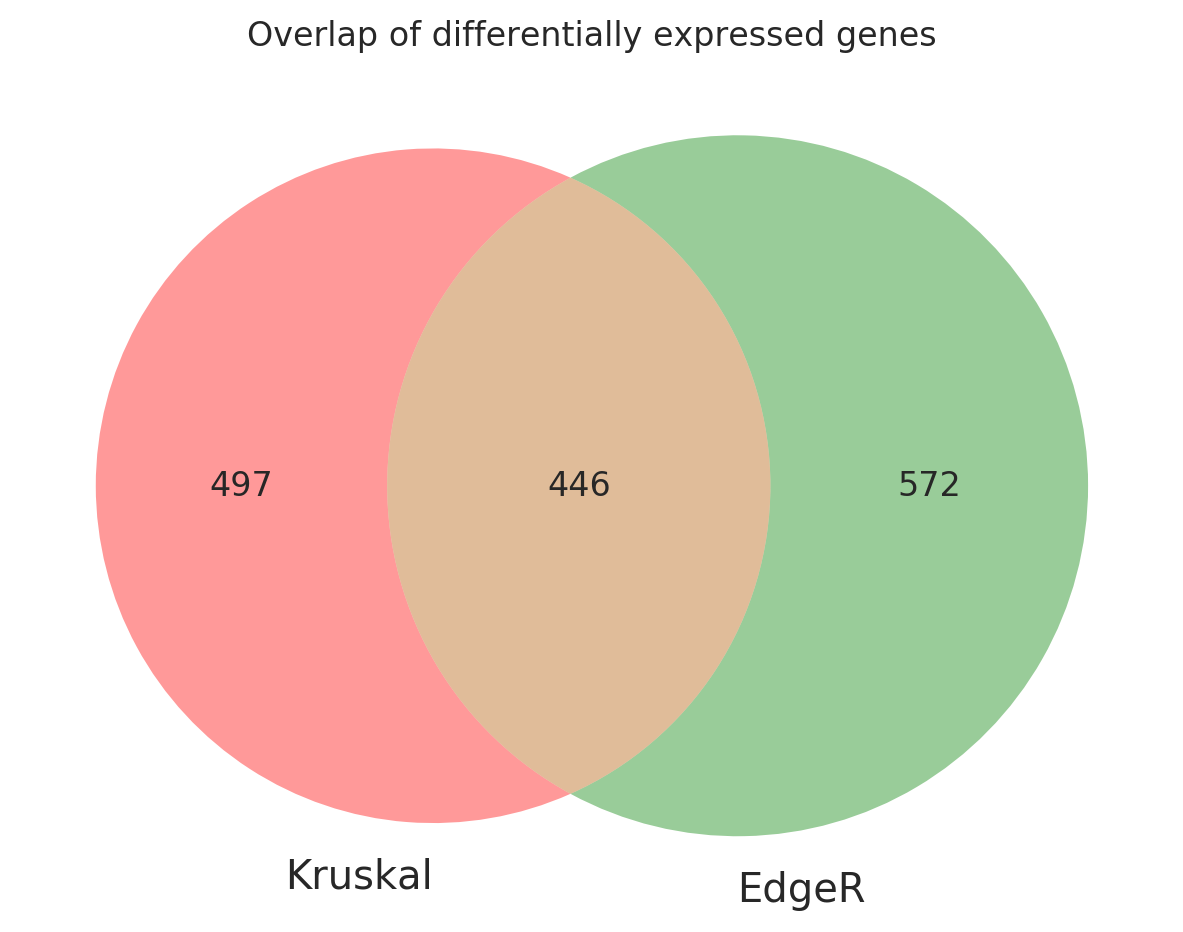

In [200]:
p_threshold = 0.05
kw_genes = set(stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values)
edger_genes = set(stat_frame[stat_frame['EdgeR pval'] < p_threshold]['gene'].values)
matplotlib_venn.venn2([kw_genes, edger_genes], set_labels = ['Kruskal', 'EdgeR'])
plt.title('Overlap of differentially expressed genes')

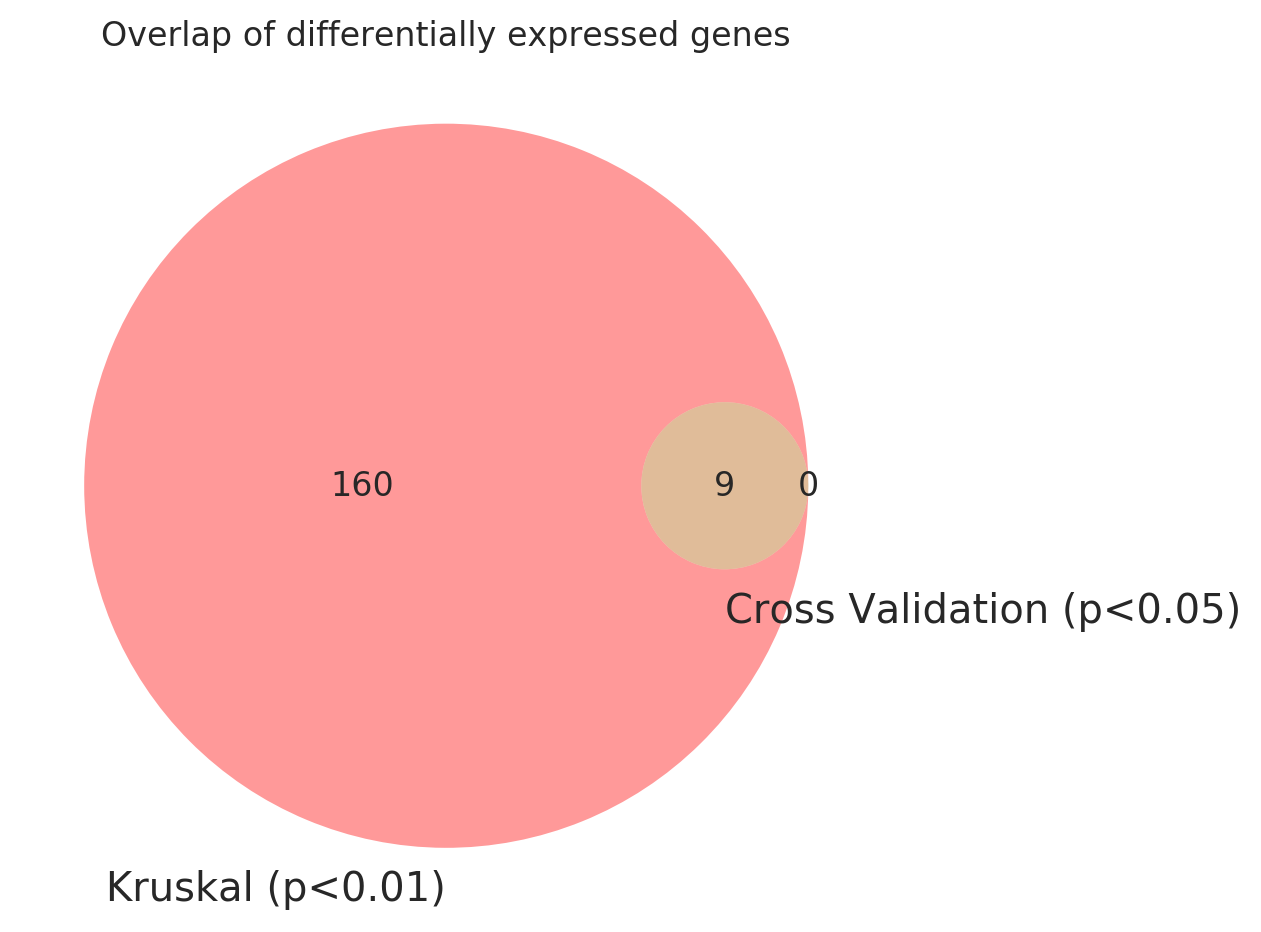

In [201]:
p_threshold = 0.01
kw_genes = stat_frame[stat_frame['KW pval'] < p_threshold]['gene'].values

# kw_genes = [x for x in kw_genes if x in idr_genes]

# edger_genes = [x for x in edger_genes if x in idr_genes]

kw_genes = set(kw_genes)
matplotlib_venn.venn2([kw_genes, set(cv_genes)], set_labels = ['Kruskal (p<'+str(p_threshold)+')', 'Cross Validation (p<0.05)'])
plt.title('Overlap of differentially expressed genes')


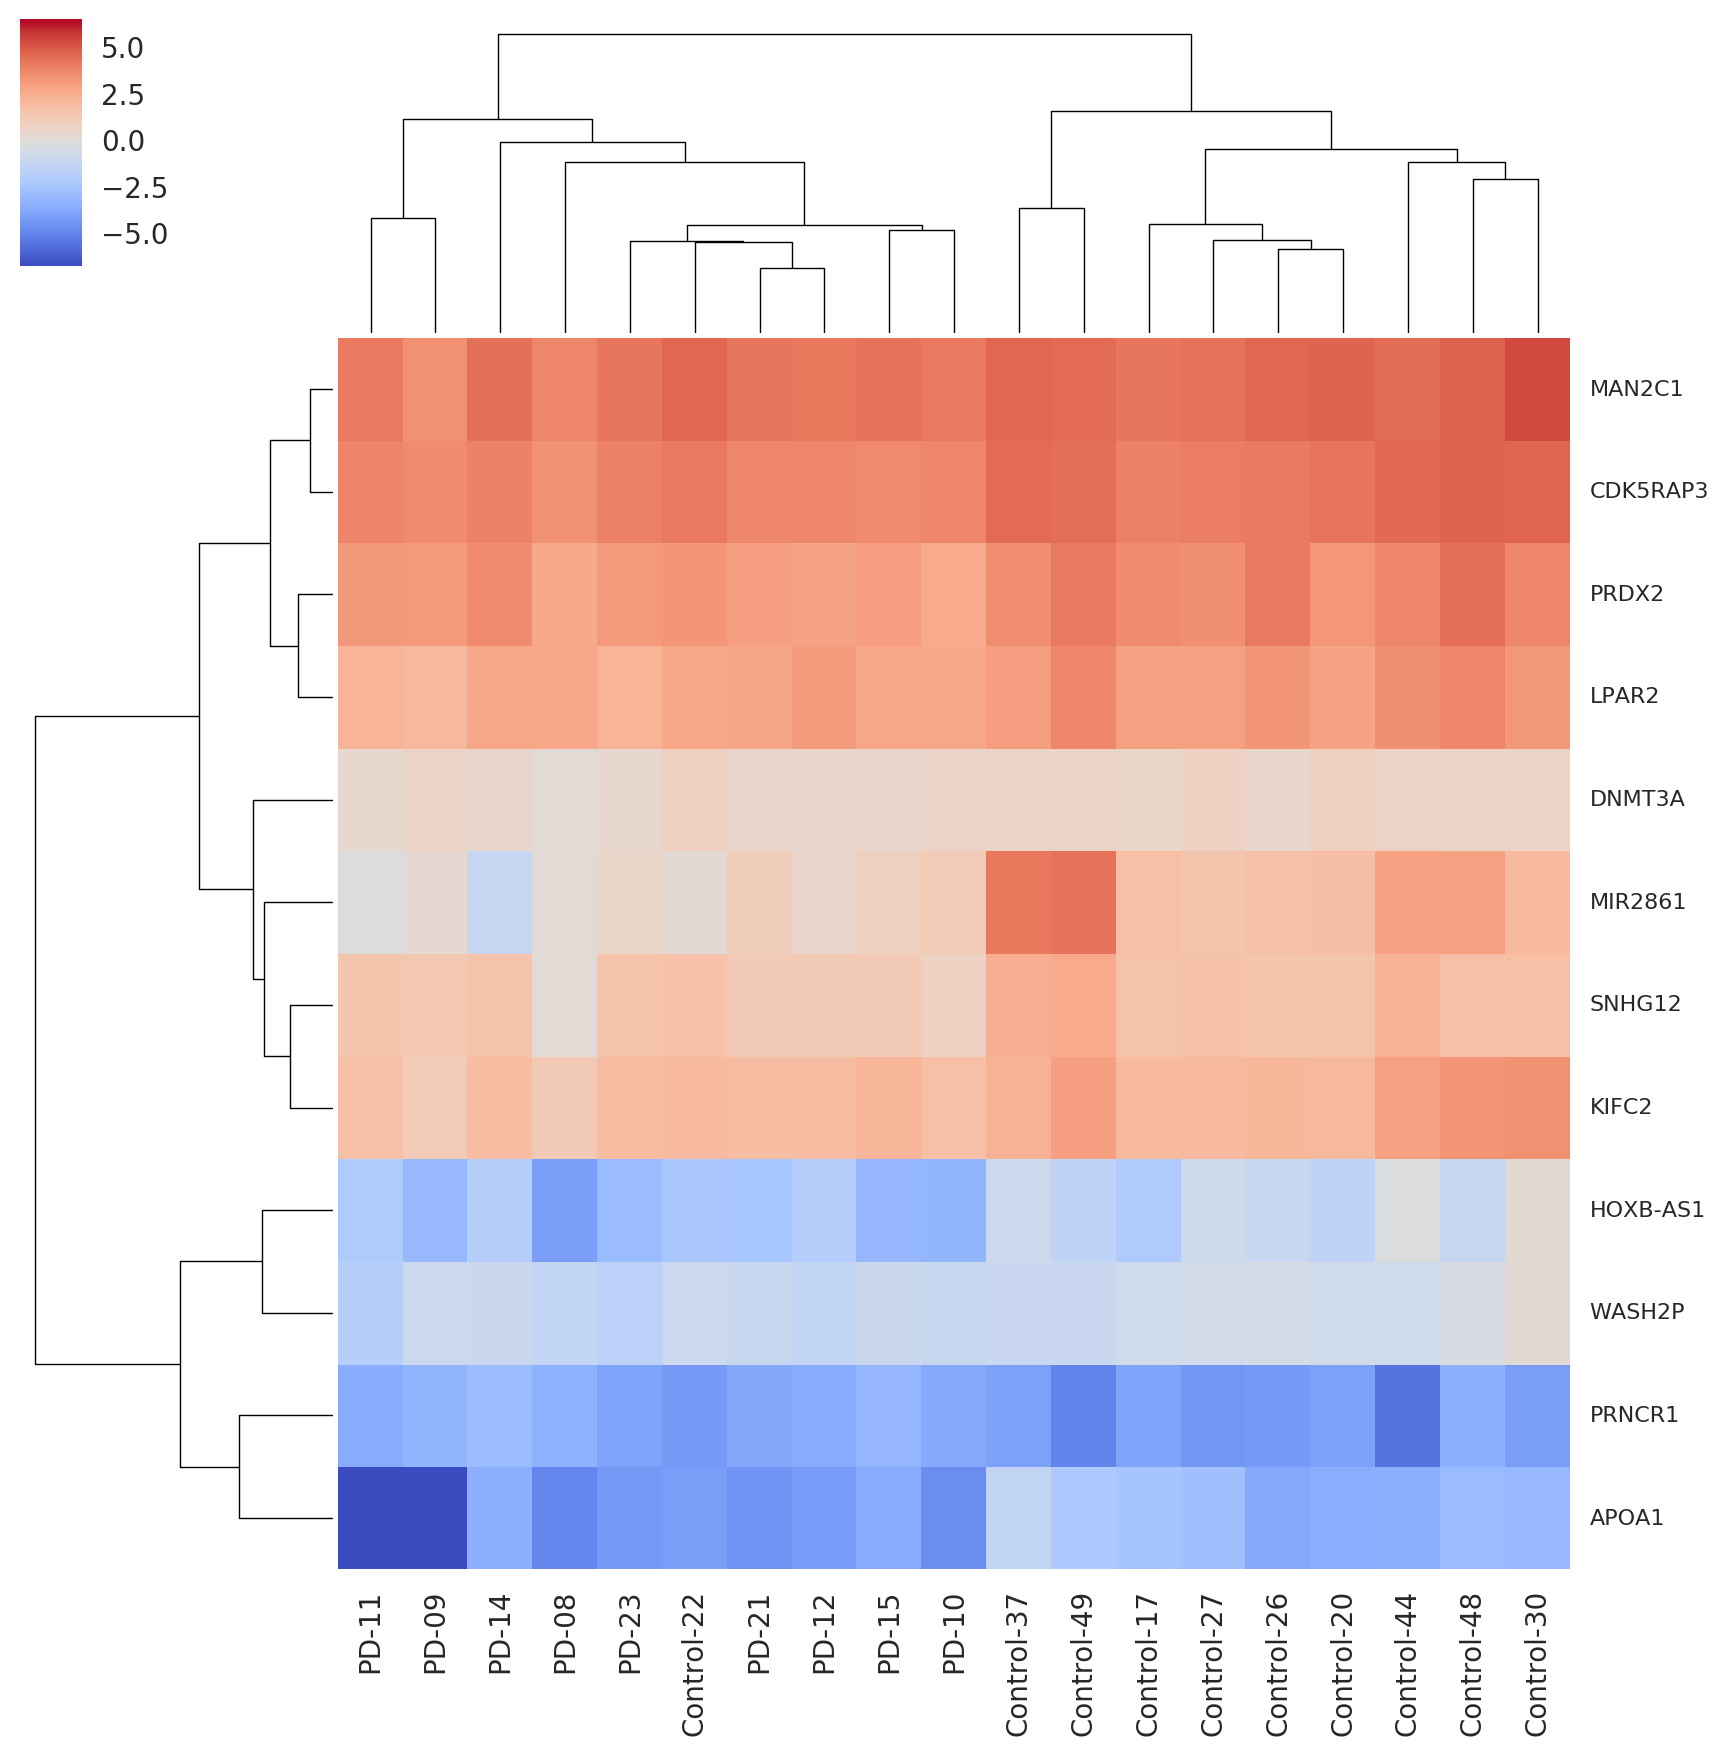

In [171]:
data = filtered_rpkm_frame[\
                    filtered_rpkm_frame.index.isin([gene_refseq_mapping[x] for x in cv_genes])]
# data = filtered_rpkm_frame[\
#                    filtered_rpkm_frame.index.isin([gene_refseq_mapping[x] for x in significant_genes_intersection])]
data.index = [refseq_gene_mapping[x] for x in data.index.values]
data = np.log2(data+0.01)
cg = sns.clustermap(data = data,
                    cmap='coolwarm',

                    );
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);

plt.savefig('./figures/genes_heatmap.pdf', bbox_inches='tight')

## Regressions

In [172]:
clinical_frame = pd.read_csv('clinical_data_160212.txt',sep='\t')
clinical_frame.index = clinical_frame['Sample Name'].values


In [173]:
samples = [x.split('_')[2] for x in clinical_frame.index.values]
simplifiedName_age_dict = dict(zip(samples,clinical_frame['Age']))
simplifiedName_duration_dict = dict(zip(samples,clinical_frame['Disease duration']))
simplifiedName_UPDRS_dict = dict(zip(samples,clinical_frame['UPDRS-III']))

In [174]:
clinical_plottingFrame = filtered_rpkm_plottingFrame.copy()

clinical_plottingFrame['age'] = [simplifiedName_age_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['duration'] = [simplifiedName_duration_dict[x] for x in clinical_plottingFrame['simplifiedName']]
clinical_plottingFrame['updrs'] = [simplifiedName_UPDRS_dict[x] for x in clinical_plottingFrame['simplifiedName']]

Age up median pearson: -0.416616747703 median spearman: -0.340799593113
Disease Duration up median pearson: 0.661338326283 median spearman: 0.694377457245
UPDRS up median pearson: 0.540410992663 median spearman: 0.645322798655


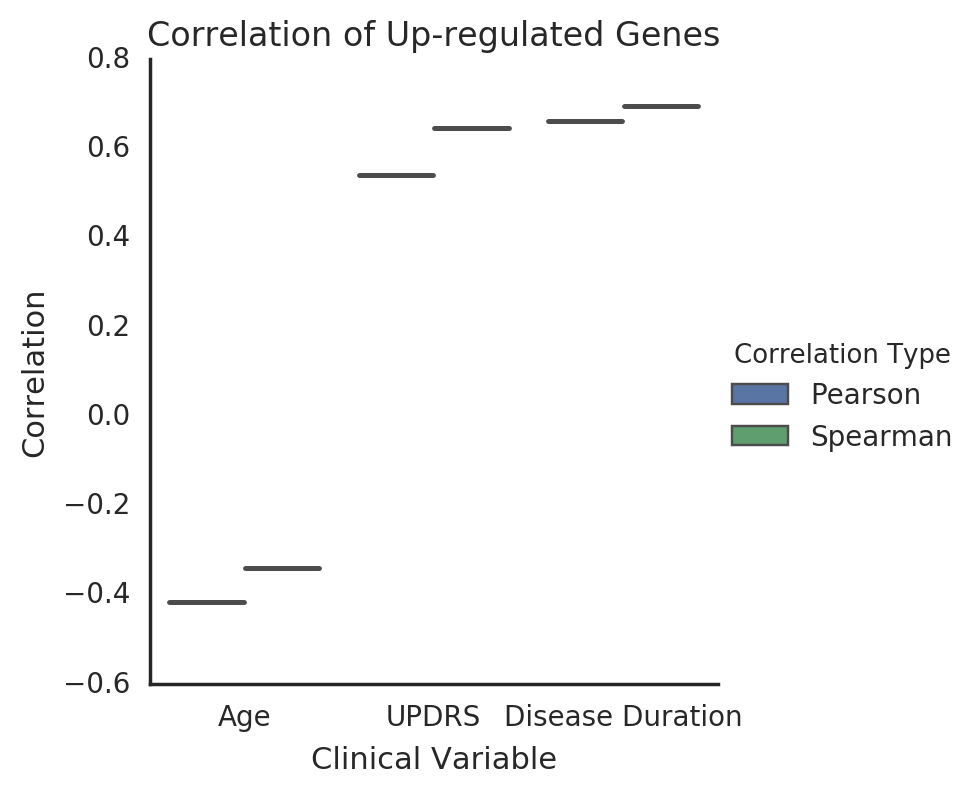

Age down median pearson: 0.281487058491 median spearman: 0.281071829371
Disease Duration down median pearson: -0.555975312842 median spearman: -0.699179514349
UPDRS down median pearson: -0.528066364607 median spearman: -0.668098897431


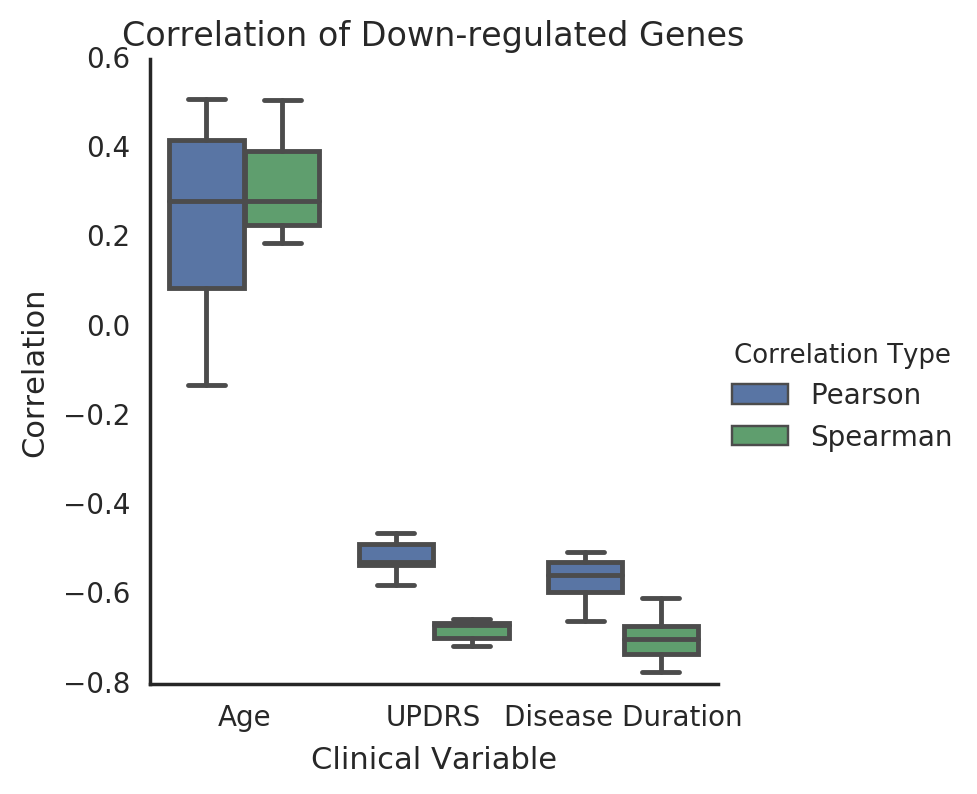

In [175]:
p_threshold = 0.01

clinical_vars = []
coefficient_types = []
coefficients = []
gene_list = stat_frame[(stat_frame['Up or Down'] == 'up') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
for cv in sorted(set(clinical_vars)):
    print(cv,'up', 'median pearson:', np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Pearson')
                                                             ]['Correlation']), 
          'median spearman:',np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Spearman')
                                                             ]['Correlation']))
sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=4)


plt.title('Correlation of Up-regulated Genes')
plt.savefig('./figures/clinical_correlation_up.pdf')
plt.show()
correlation_frame.to_csv('gene_clinical_correlation_up.tsv',sep='\t')
clinical_vars = []
coefficient_types = []
coefficients = []
# gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['EdgeR pval'] <p_threshold)]['gene']
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['KW pval'] <p_threshold)]['gene']


gene_list = [x for x in gene_list if x in cv_genes]


genes = []
for gene in set(clinical_plottingFrame[clinical_plottingFrame['gene'].isin(gene_list)]['gene'].values):
    currentVals = clinical_plottingFrame[clinical_plottingFrame['gene'] == gene]
    rpkms = currentVals['rpkm'].values
    ages = currentVals['age'].values
    updrs = currentVals['updrs'].values
    duration = currentVals['duration'].values

    r_pearson,p_pearson = stats.pearsonr(rpkms, ages)
    r_spearman,p_spearman = stats.spearmanr(rpkms, ages)
    
    # age testing 
    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Age')
    clinical_vars.append('Age')


    # updrs testing
    r_pearson,p_pearson = stats.pearsonr(rpkms, updrs)
    r_spearman,p_spearman = stats.spearmanr(rpkms, updrs)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('UPDRS')
    clinical_vars.append('UPDRS')
    
    r_pearson,p_pearson = stats.pearsonr(rpkms, duration)
    r_spearman,p_spearman = stats.spearmanr(rpkms, duration)

    coefficients.append(r_pearson)
    coefficient_types.append('Pearson')
    coefficients.append(r_spearman)
    coefficient_types.append('Spearman')
    clinical_vars.append('Disease Duration')
    clinical_vars.append('Disease Duration')
    
    genes = genes + 6 * [gene]
    


correlation_frame = pd.DataFrame({'Clinical Variable':clinical_vars,
                                 'Correlation Type': coefficient_types,
                                 'Correlation':coefficients,
                                 'Gene':genes})
for cv in sorted(set(clinical_vars)):
    print(cv,'down', 'median pearson:', np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Pearson')
                                                             ]['Correlation']), 
          'median spearman:',np.median(correlation_frame[(correlation_frame['Clinical Variable']==cv) &
                                                              (correlation_frame['Correlation Type']=='Spearman')
                                                             ]['Correlation']))

sns.factorplot(x='Clinical Variable', 
               y='Correlation', 
               hue = 'Correlation Type', 
               data = correlation_frame, 
               kind='box', whis=1, showfliers=False, size=4)
plt.title('Correlation of Down-regulated Genes')
correlation_frame.to_csv('gene_clinical_correlation_down.tsv',sep='\t')



plt.savefig('./figures/clinical_correlation_down.pdf')

## PCA Analysis

In [176]:
import sklearn

from sklearn import preprocessing

from sklearn import decomposition

from matplotlib import patches as mpatches

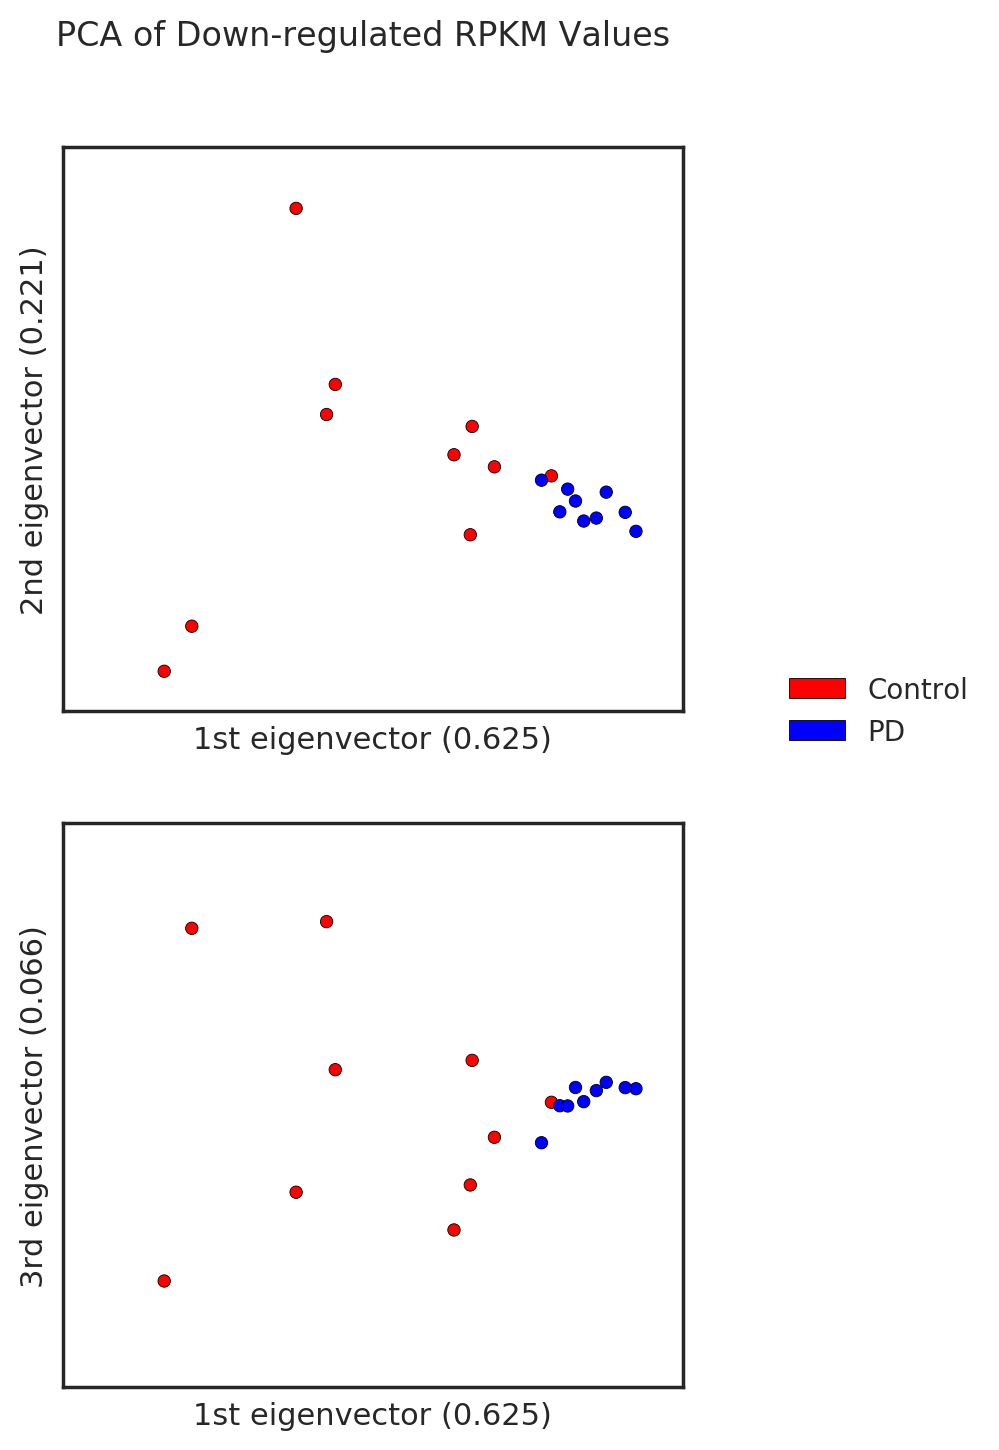

In [177]:
p_threshold = 0.005
gene_list = stat_frame[(stat_frame['Up or Down'] == 'down') & (stat_frame['KW pval'] <p_threshold)]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of Down-regulated RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('./figures/pca_2d_down.pdf', bbox_inches='tight')
plt.show()

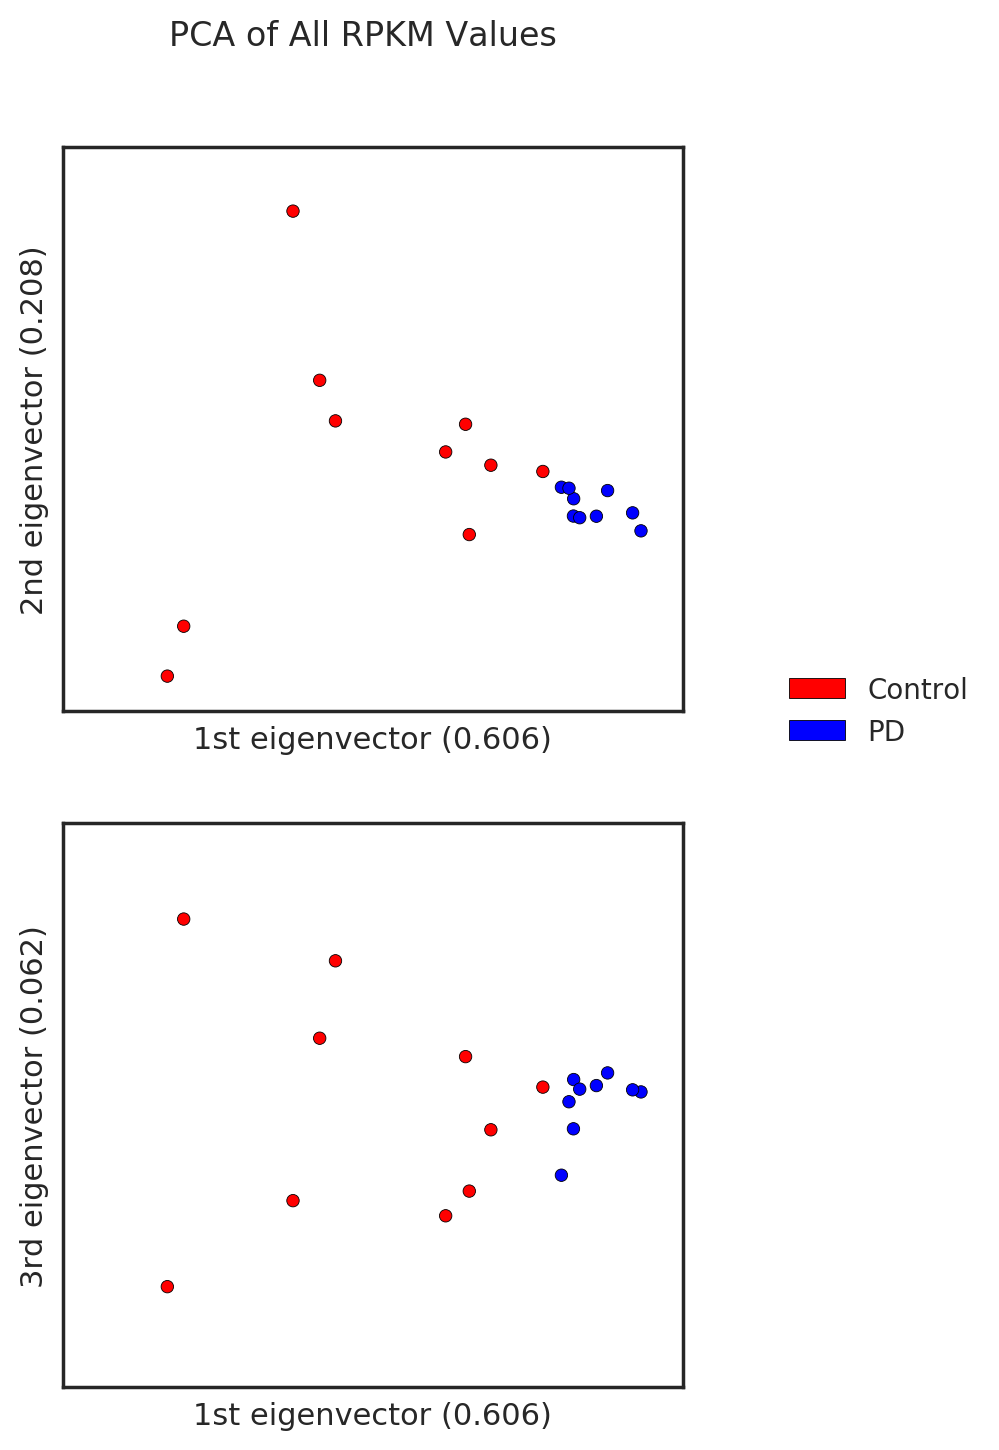

In [178]:
p_threshold = 0.05
gene_list = stat_frame[stat_frame['KW pval'] <p_threshold]['gene']
idr_genes = stat_frame[stat_frame['passed IDR'] == True]['gene'].values
gene_list = [x for x in gene_list if x in cv_genes]
# refseq_list = [gene_refseq_mapping[x] for x in gene_list]
# features = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(refseq_list)]
features = idr_rpkm_frame[idr_rpkm_frame.index.isin(gene_list)]


normalized_features = pd.DataFrame(preprocessing.normalize(features,axis=1))
normalized_features.columns = features.columns
normalized_features.index = features.index

colors = ['Blue' if 'PD' in x else 'red' for x in normalized_features.columns.values]


model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normalized_features.T)
explained_variance_ratios = model.explained_variance_ratio_

sns.set_style('white')
f, axs = plt.subplots(2,1, figsize=(4,8))
                
plt.suptitle('PCA of All RPKM Values')

# 1st and 2nd principal component
plt.subplot(2,1,1)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

# legend
classes = sorted(set(filtered_summary_frame['simpleTreatment'].values))
class_colours = ['red', 'blue']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 0))

# 1st and 3rd principal component
plt.subplot(2,1,2)               
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], c=colors, s=20)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])

plt.savefig('./figures/pca_2d_all.pdf', bbox_inches='tight')
plt.show()

## Gene Ontology Analysis

In [191]:
p_threshold = 0.01
gene_list_up = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'up')]['gene'].values
gene_list_up = [x for x in gene_list_up if x in cv_genes]
gene_list_down = stat_frame[(stat_frame['KW pval'] <p_threshold) & (stat_frame['Up or Down'] == 'down')]['gene'].values
gene_list_down = [x for x in gene_list_down if x in cv_genes]

# write target genes file
outFile = open('go_genes_up.txt', 'w')
for g in gene_list_up:
    outFile.write(g.upper()+ '\n')
outFile.close()

outFile = open('go_genes_down.txt', 'w')
for g in gene_list_down:
    outFile.write(g.upper()+ '\n')
outFile.close()

# write background file
outFile = open('background.txt', 'w')
for g in [refseq_gene_mapping[x] for x in filtered_rpkm_frame.index.values]:
    outFile.write(g.upper() + '\n')
outFile.close()

In [96]:
os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jtao/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')

# print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_up.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_up.txt')

# print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./go_genes_down.txt ./background.txt /home/jenhan/analysis/go_analysis/human_association --pval=0.05 > ./go_results_down.txt')




256

In [ ]:
go_frame_up = pd.read_csv('go_results_up.txt',sep='\t', skiprows=2)

In [ ]:
go_frame_down = pd.read_csv('go_results_down.txt',sep='\t', skiprows=2)

In [ ]:
gene_go_dict = {}
go_gene_dict = {}
with open('/home/jenhan/analysis/go_analysis/human_association') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    gene = tokens[0]
    terms = tokens[1].split(';')
    gene_go_dict[gene] = terms
    for t in terms:
        if t in go_gene_dict:
            go_gene_dict[t].append(gene)
        else:
            go_gene_dict[t] = [gene]

        

In [ ]:
go_description_dict = dict(zip(go_frame_up['id'].values, go_frame_up['description'].values))
go_description_dict.update(dict(zip(go_frame_down['id'].values, go_frame_down['description'].values)))

In [ ]:
term_children_dict = {
'GO:0060563':set(['GO:0060563','GO:0061453', 'GO:0030318', 'GO:0050933', 'GO:0042491', 'GO:0050934', 'GO:0060531', 'GO:0061104', 'GO:0061102', 'GO:0061103', 'GO:0061100', 'GO:0061101', 'GO:0060129', 'GO:0071895']),
'GO:0046328':set(['GO:0046328','GO:0007256', 'GO:0046329', 'GO:0046330', 'GO:0042655', 'GO:0043508', 'GO:0007257', 'GO:0043506', 'GO:0043507']),
'GO:0030217':set(['GO:0046632', 'GO:0061470', 'GO:0002361', 'GO:0042093', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:1904157', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002308', 'GO:0043367', 'GO:0002306', 'GO:0002305', 'GO:0033077', 'GO:0033078', 'GO:1904155', 'GO:0072539', 'GO:0045066', 'GO:0045063', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0045065', 'GO:0045064', 'GO:0002299', 'GO:0002298', 'GO:0042492', 'GO:0043379', 'GO:0043374']),
'GO:0042110': set(['GO:0002289', 'GO:0033080', 'GO:0046633', 'GO:0046632', 'GO:0061470', 'GO:0046630', 'GO:0042722', 'GO:0002303', 'GO:0002302', 'GO:0002301', 'GO:0002300', 'GO:1904156', 'GO:0001866', 'GO:0001865', 'GO:0002304', 'GO:0002307', 'GO:0002309', 'GO:0002308', 'GO:0043367', 'GO:1904157', 'GO:0002305', 'GO:0030217', 'GO:1904155', 'GO:0046631', 'GO:0035709', 'GO:0045063', 'GO:0045066', 'GO:0045065', 'GO:0045064', 'GO:0042492', 'GO:0043379', 'GO:0043316', 'GO:0035739', 'GO:0043374', 'GO:0046629', 'GO:0002306', 'GO:0036037', 'GO:0050798', 'GO:0042093', 'GO:0002286', 'GO:0002287', 'GO:0002288', 'GO:0042098', 'GO:0002361', 'GO:0035712', 'GO:0035741', 'GO:0035740', 'GO:0051132', 'GO:0035742', 'GO:0033077', 'GO:0033079', 'GO:0033078', 'GO:0001777', 'GO:0072539', 'GO:0002291', 'GO:0002290', 'GO:0002293', 'GO:0002292', 'GO:0002294', 'GO:0061485', 'GO:0002299', 'GO:0002298', 'GO:0002310', 'GO:0002311', 'GO:0035710', 'GO:0035711'])
                     }

In [ ]:
_genes = []
_descriptions = []

for term in term_children_dict.keys():
    genes = []
    for t in term_children_dict[term]:
        if t in go_gene_dict:
            genes = genes+ go_gene_dict[t]
    genes = sorted(set(genes))
    print('***',term, go_description_dict[term], len(genes))
    for g in genes:
        if g.upper() in cv_genes or g in cv_genes:
            print(g)
            _genes.append(g)
            _descriptions.append(go_description_dict[term])


gene_description_dict = dict(zip(_genes, _descriptions))

In [ ]:
sig_genes = _genes
go_plotting_frame = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene'].isin(sig_genes)]
gene_pval_dict = dict(zip(stat_frame['gene'].values, stat_frame['KW pval'].values))
go_plotting_frame['Term'] = [gene_description_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame['p-value']=[gene_pval_dict[x] for x in go_plotting_frame['gene']]
go_plotting_frame.columns = ['Gene', 'Refseq', 'RPKM', 'Sample Name', 'Group', 'Term', 'p-value']

In [ ]:
! if [ ! -d ./bar_plots ]; then mkdir ./bar_plots; fi
for term in sorted(set(go_plotting_frame['Term'].values)):
    sns.factorplot(data = go_plotting_frame[go_plotting_frame['Term']==term].sort('p-value'), 
                   x='Gene', 
                   y='RPKM', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
    plt.title(term)
    plt.savefig('./bar_plots/'+'_'.join(term.split())+'.pdf')
    plt.show()
sns.factorplot(data = go_plotting_frame[go_plotting_frame['Gene'].isin(['NCOR1','RC3H1','ZFP36L2'])], 
              x='Gene', 
                   y='RPKM', 
                   hue = 'Group', 
                   kind='bar',
                   hue_order = ['Control', 'PD'],
                   size=10)
plt.title('T cell differentiation')
plt.savefig('./bar_plots/'+'_'.join('T cell differentiation'.split())+'.pdf')



In [ ]:
data = data=go_plotting_frame

gene_foldChange_dict = dict(zip(stat_frame['gene'], stat_frame['fold change']))
data['fold change'] = [gene_foldChange_dict[x] for x in data['Gene']]

In [ ]:
sns.factorplot(x='Gene', 
               y='RPKM', 
               kind='bar',
               data=data, 
               hue='Group',
              size=10)
plt.savefig('bar_plot_all.pdf')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


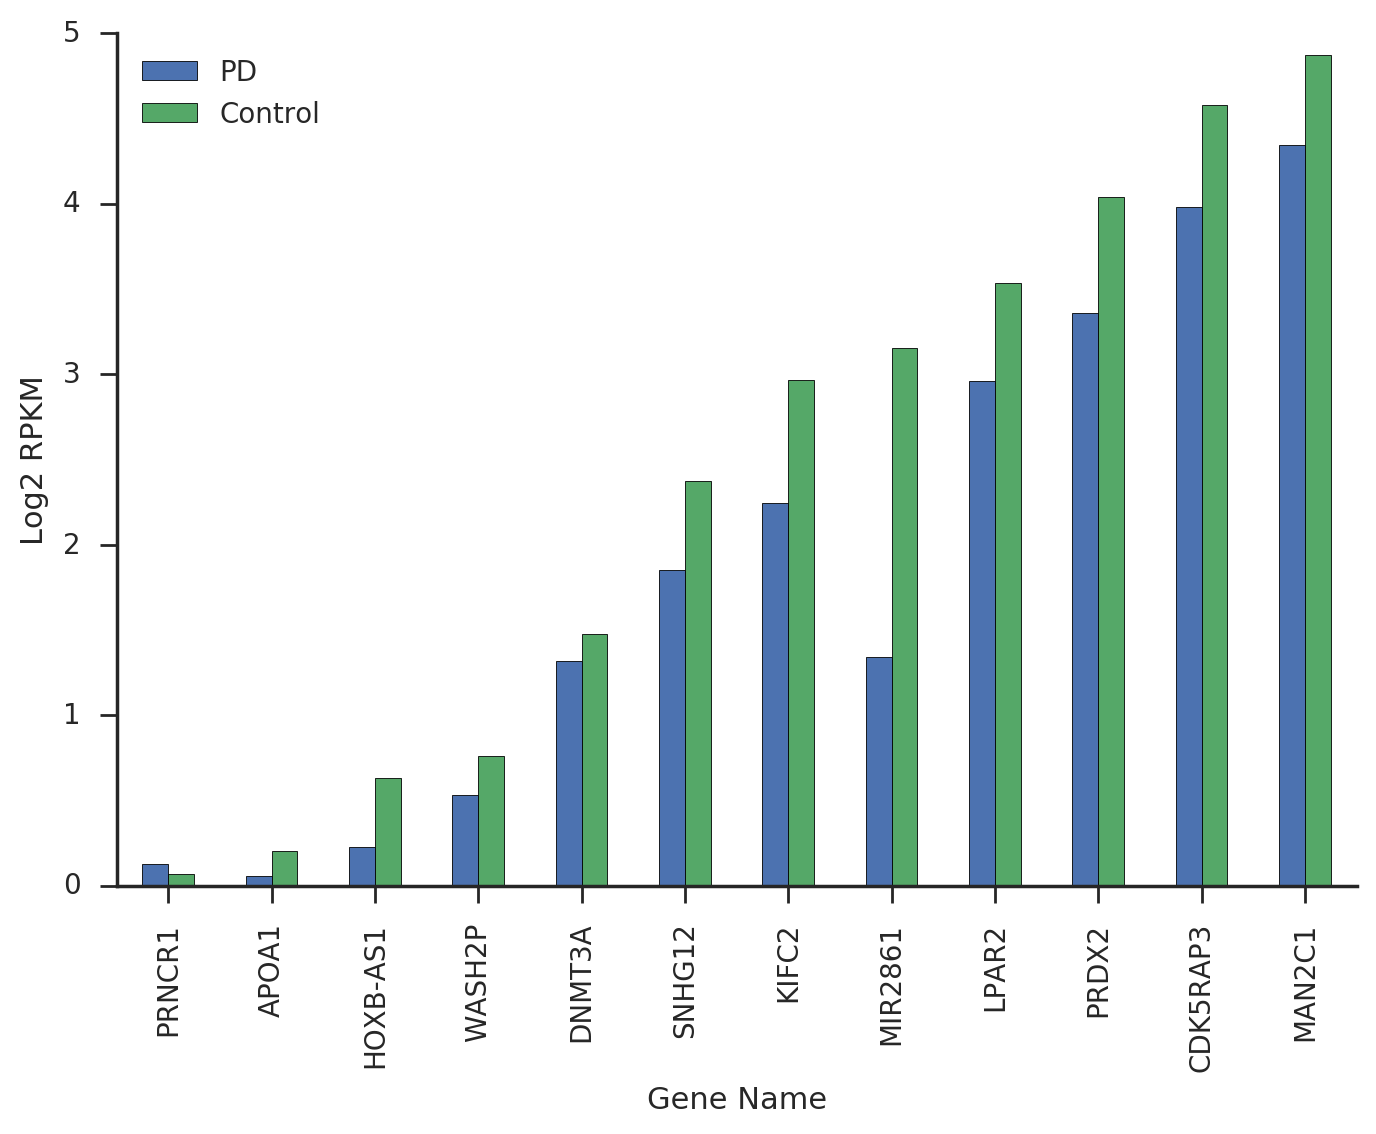

In [192]:
data = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(cv_genes)]
logged_data = np.log2(data+1)
logged_data = logged_data.sort('Control')
with sns.axes_style('ticks', {'axes.grid':False, 'grid.color':'white'}):
    logged_data.plot(kind='bar', sort_columns=True)
    sns.despine()
    plt.ylabel('Log2 RPKM')
    plt.xlabel('Gene Name')
plt.savefig('./figures/allGenes_barplot.pdf',bbox_inches='tight')

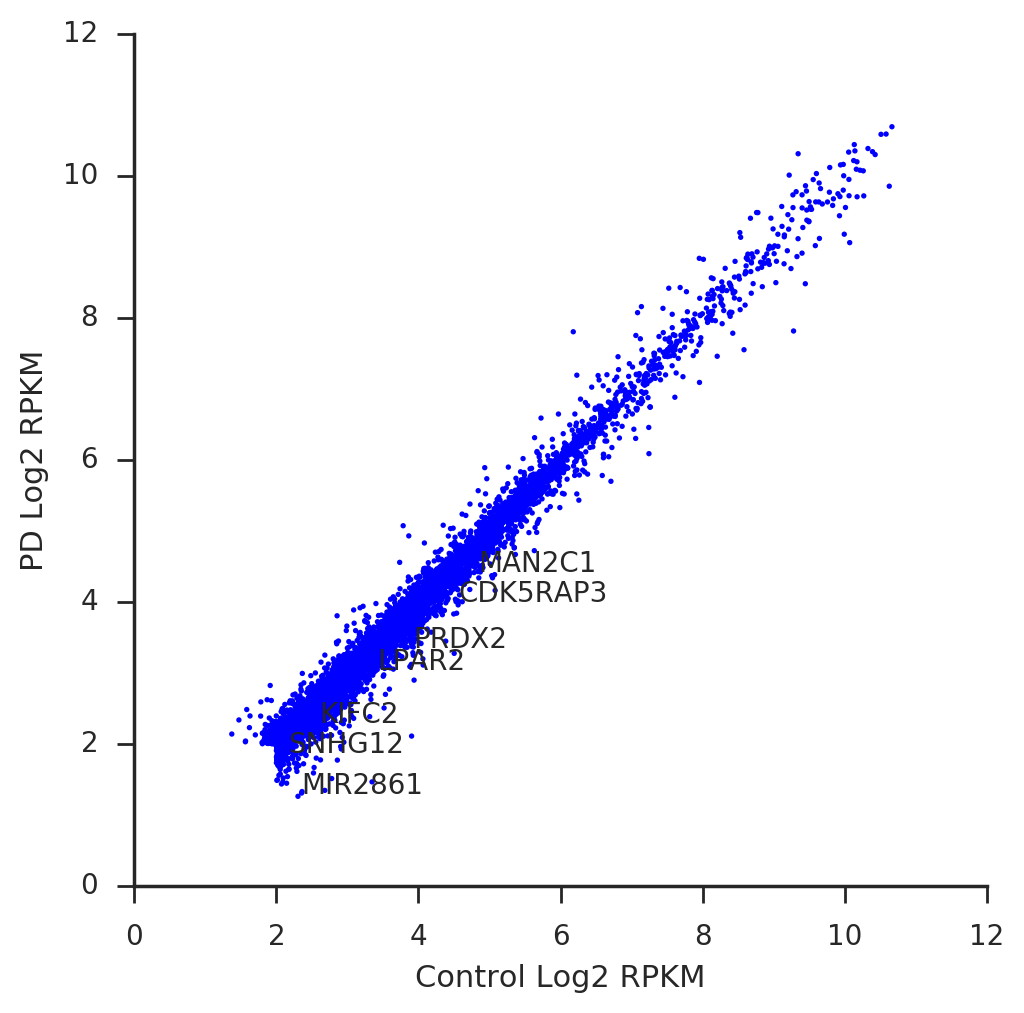

In [187]:
reads1 = np.log2(idr_rpkm_median_frame['Control']+1)
reads2 = np.log2(idr_rpkm_median_frame['PD']+1)
names = idr_rpkm_median_frame.index.values

# reads1 = np.log2(idr_rpkm_mean_frame['Control']+1)
# reads2 = np.log2(idr_rpkm_mean_frame['PD']+1)
# names = idr_rpkm_mean_frame.index.values

tuples = zip(reads1, reads2, names)
filtered_tuples = [x for x in tuples if x[0] >=2 or x[1]>=2]

filtered_reads1 = [x[0] for x in filtered_tuples]
filtered_reads2 = [x[1] for x in filtered_tuples]

with sns.axes_style('ticks'):
    plt.scatter(filtered_reads1, filtered_reads2,
                marker = '.', s=15,
               c='blue',
               edgecolors='none', )
    for x, y, label in filtered_tuples:
        fold = x/y
    #     if fold >= 1.3 or fold <=1/1.3:
        if label in cv_genes:
            plt.annotate(label, size=10, xy=(x,y))

    ax = plt.gca()
    ax.set_xlim((0,12))
    ax.set_ylim((0,12))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    plt.xlabel('Control Log2 RPKM')
    plt.ylabel('PD Log2 RPKM')
    sns.despine()
    plt.savefig('./figures/scatterplot_annotated.pdf',bbox_inches='tight')